# QMSB notebook: class summary and complementary notes

In [1]:
from stimator import read_model
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from tqdm import tqdm
import SteadyState as ss

def script(file,k,value,dependent=False):
    cut=file.split('\n')
    #cut[0] = cut[0] + str(k)
    for line in cut:
        if 'title' in line:
            cut[cut.index(line)] = line + ' ' + str(k) + '=' + str(value)
        if str(k) in line and ',' not in line:
            replace = line.split('=')
            replace[-1]=str(value)
            new = ' = '.join(replace)
            cut[cut.index(line)] = new
            final = '\n'.join(cut)
            return str(final)
        if dependent == True:
            if 'init' in line:
                dep_variable = line.split(':')[-1].split(')')[0].split(',')
                for variable in dep_variable:
                    if str(k) in variable:
                        var_to_change = variable.split('=')
                        var_to_change[-1] = str(value)
                        dep_variable[dep_variable.index(variable)]='='.join(var_to_change)
                cut[cut.index(line)] = 'init: ' + ','.join(dep_variable) + ')'
                final = '\n'.join(cut)
                return str(final)

def parameter_extraction(model:str):
    parameters = {}
    for line in model.split('\n'):
        if '=' in line and 'init' not in line and 'title' not in line and '~' not in line:
            parm_value = line.split('=')
            parameter = parm_value[0].strip()
            value = float(parm_value[-1].strip())
            parameters[parameter] = value
    return parameters

# Modify default font settings
matplotlib.rcParams['font.family'] = 'times new roman'
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.weight'] = 'normal'
matplotlib.rcParams['axes.labelcolor'] = 'black'

# QMSB - TP2 summary and complementary graphs

## Plotting a model

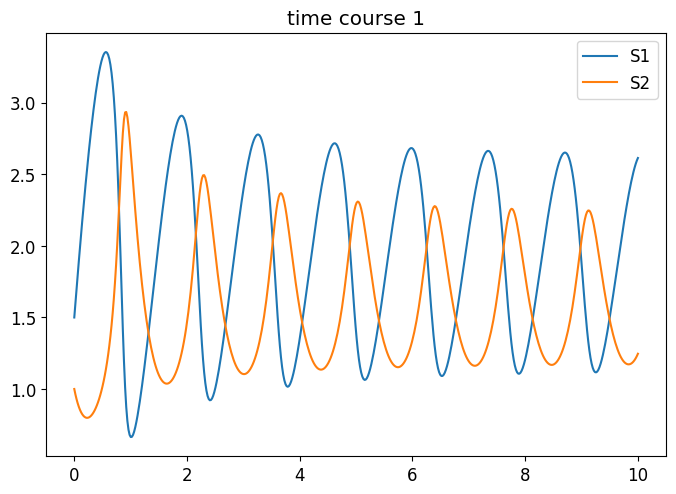

In [3]:
negative_feeback = """
r1: -> S1, k0
r2: S1 -> S2, k1*S1*(1+(S2/K)**n)
r3: S2 ->, k2*S2

k0 = 8
k1 = 1
k2 = 5
K = 1
n = 2.5

init: (S1 = 1.5, S2 = 1)

"""
negative_feeback = script(script(negative_feeback,'n',2.5),'k1',1)

nf_model = read_model(negative_feeback).solve(tf=10)
nf_model.plot()
plt.show()

nfmodel_s1 = nf_model[0]
nfmodel_s2 = nf_model[1]

## Find the Phase Space of a model

In [2]:
def model(t,state,parameter):
    V0 = parameter['k0']
    V1 = parameter['k1']*state['S1']*(1+(state['S2']/parameter['K'])**parameter['n'])
    V2 = parameter['k2']*state['S2']

    dS1 = V0 - V1
    dS2 = V1 - V2
    return np.array([dS1,dS2])

parameter = parameter_extraction(negative_feeback)

intervali = [0,20]
intervalj = [0,20]
size = 21

rate_record = pd.DataFrame()
for x in np.linspace(intervali[0],intervali[1],size)[1:]: # set the points in the phase plot for one of the parameters
    for y in np.linspace(intervalj[0],intervalj[1],size)[1:]: # set the points for the other parameter
        state = {
            'S1':5*x/20,
            'S2':5*y/20
        }
        vector = model(0,state,parameter)
        norm_vector_model = np.linalg.norm(vector)
        norm_vector = vector*0.1*(1/norm_vector_model) # normalize the rate vector for dS2
        record = pd.DataFrame({ # add the information into a df
            'State 1':state['S1'],
            'State 2':state['S2'],
            'Rate 1':norm_vector[0],
            'Rate 2':norm_vector[1]
                }, index = [0])
        rate_record = pd.concat([rate_record,record],ignore_index=True)

plt.figure(figsize=(7,5))
for idx, row in rate_record.iterrows(): # interates through the rows of a df unfolding the index from them
    plt.arrow(row['State 1'], row['State 2'], row['Rate 1'], row['Rate 2'], head_width=0.4*(row['Rate 1']**2+row['Rate 2']**2)**(1/2), head_length=0.6*(row['Rate 1']**2+row['Rate 2']**2)**(1/2),fc='black', ec='grey',alpha=0.7)
plt.plot(nfmodel_s1,nfmodel_s2,color='darkred')
plt.title('Limitting Cycle')
plt.xlabel('S1')
plt.ylabel('S2')
plt.show()


NameError: name 'negative_feeback' is not defined

# QMSB - TP3 summary

## Test model

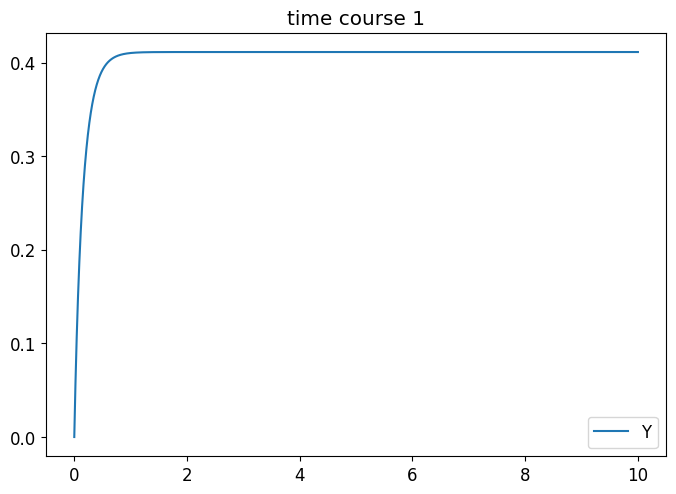

In [4]:
test_model = """
r1: -> Y, B*(1/(Y+k1))
r2: Y ->, k2*Y

k1 = 0.5
k2 = 0
B = 1.5

init: (Y=0)

"""

model = read_model(test_model).solve(tf=10,npoints=10000)
model_2 = read_model(script(test_model,'k2',4)).solve(tf=10,npoints=10000)
model_2.plot()
plt.show()


## Negative Autoregulation (NAR)

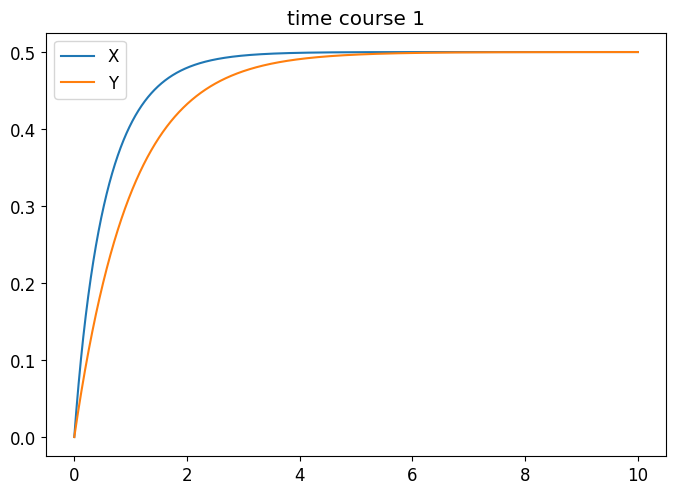

In [5]:
NAR = """

r1: -> X, k1*(K/(K+X))
r2: X ->, k2*X
r3: -> Y, k3
r4: Y ->, k4*Y
k1 = 1
k2 = 1
k3 = 0.5
k4 = 1
K = 0.5
"""

model = read_model(NAR).solve(tf=10,npoints=10000)
model.plot()
plt.show()
#print("SS is ",model[0][-1]," which is equal to ",(-0.5+(0.5**2+4*0.25)**(1/2))/2)

## PAR models

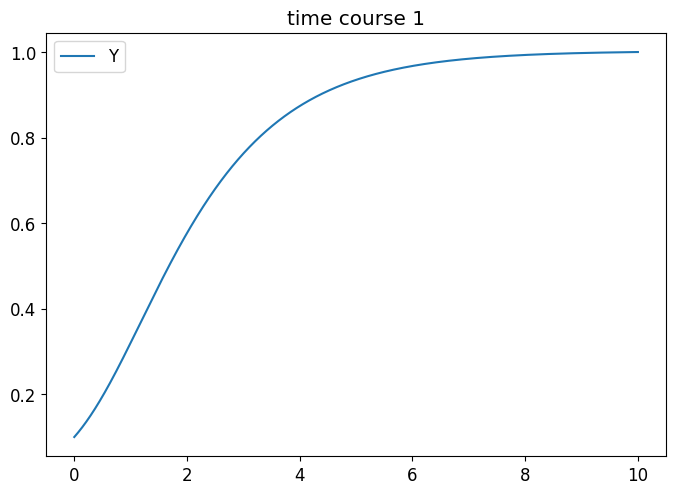

In [6]:
PAR = """

r1: -> Y, B*X*Y**n/((K1+X)*(Ky**n+Y**n))
r2: Y ->, k2*Y


B=2.254
k2=1
K1=0.5
Ky=0.5
n=1
X=1
init: (Y=0.1,Z=0.1)

"""

par_model = read_model(PAR).solve(tf = 10, npoints = 10000)
par_model.plot()
plt.show()

## Coherent Feed Foward Loop

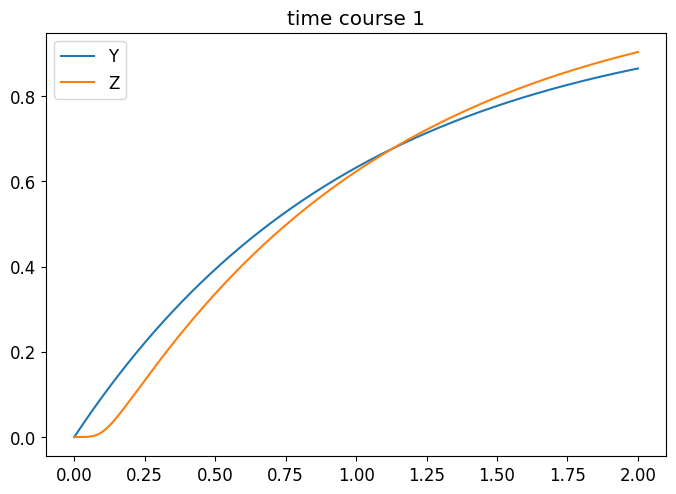

0.8646647182634781 0.9032797318370439


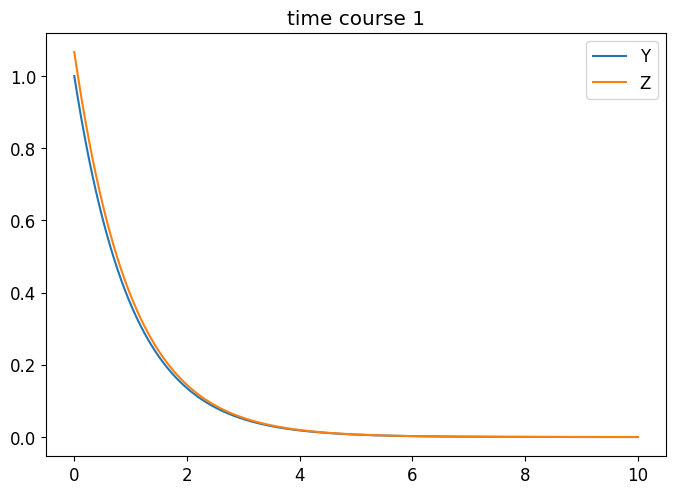

In [7]:
C_FFL_AND = """
r3: -> Y, k3*X/(Kxy+X)
r4: Y ->, k4*Y
r5: -> Z, k5*(Y**n/(Kzy**n+Y**n))*(X/(Kxy+X))
r6: Z ->, k6*Z

X = 1
k3 = 1.5
k4 = 1
k5 = 1.6
k6 = 1
Kxy = 0.5
Kzx = 0.1
Kzy = 0.1
n=4
init: (Y=0)

!! Y Z
"""

model = read_model(C_FFL_AND).solve(tf=2,npoints=10000)
model.plot()
plt.show()
print(model[0][-1],model[1][-1])

C_FFL_AND_DECAY = """
r3: -> Y, k3*X/(Kxy+X)
r4: Y ->, k4*Y
r5: -> Z, k5*(Y**n/(Kzy**n+Y**n))*(X/(Kxy+X))
r6: Z ->, k6*Z

X = 0
k3 = 1.5
k4 = 1
k5 = 1.6
k6 = 1
Kxy = 0.5
Kzx = 0.1
Kzy = 0.1
n=4

init: (Y=0.9999545983434023,Z=1.0665050716179032)

!! Y Z
"""

model = read_model(C_FFL_AND_DECAY).solve(tf=10,npoints=10000)
model.plot()
plt.show()

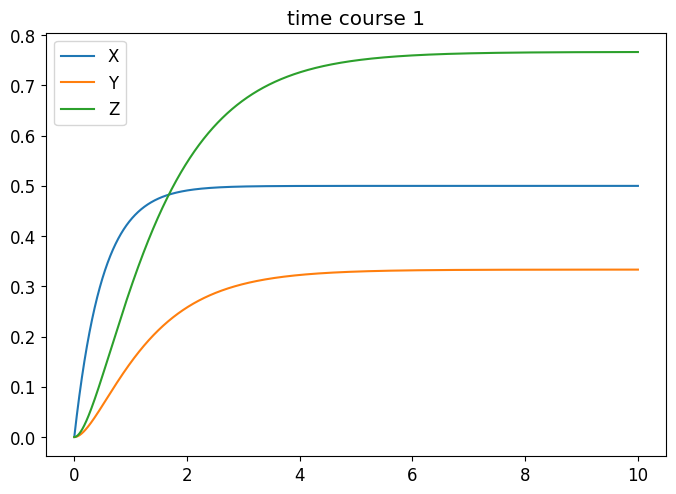

0.49999999905281856 0.3333066936147239 0.7664889872844108


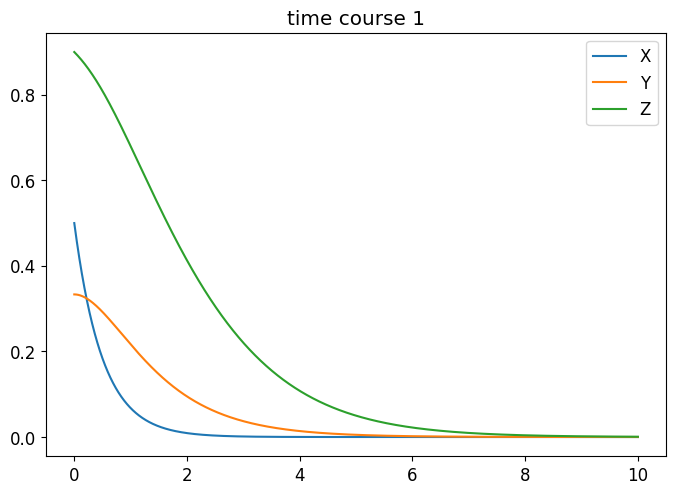

In [8]:
C_FFL_OR = """
r1: -> X, k1*Sx
r2: X ->, k2*X
r3: -> Y, k3*X/(Kxy+X)
r4: Y ->, k4*Y
r5: -> Z, k5*(Y/(Kzy+Y))+k5*(X/(Kzx+X))-(k5*(Y/(Kzy+Y))*(X/(Kxy+X)))
r6: Z ->, k6*Z

Sx = 1
k1 = 1
k2 = 2
k3 = 1
k4 = 1
k5 = 1
k6 = 1
Kxy = 1
Kzx = 0.5
Kzy = 0.5

init: (X=0, Y=0, Z=0)

"""

model = read_model(C_FFL_OR).solve(tf=10,npoints=10000)
model.plot()
plt.show()
print(model[0][-1],model[1][-1],model[2][-1])

C_FFL_OR_DECAY = """
r1: -> X, k1*Sx
r2: X ->, k2*X
r3: -> Y, k3*X/(Kxy+X)
r4: Y ->, k4*Y
r5: -> Z, k5*(Y/(Kzy+Y))+k5*(X/(Kzx+X))-(k5*(Y/(Kzy+Y))*(X/(Kxy+X)))
r6: Z ->, k6*Z

Sx = 0
k1 = 1
k2 = 2
k3 = 1
k4 = 1
k5 = 1
k6 = 1
Kxy = 1
Kzx = 0.5
Kzy = 0.5

init: (X=0.49999999873533285, Y=0.3333066936356647, Z=0.899749162842725)

"""

model_decay = read_model(C_FFL_OR_DECAY).solve(tf=10,npoints=10000)
model_decay.plot()
plt.show()


## Incoherent Feed Foward Loop

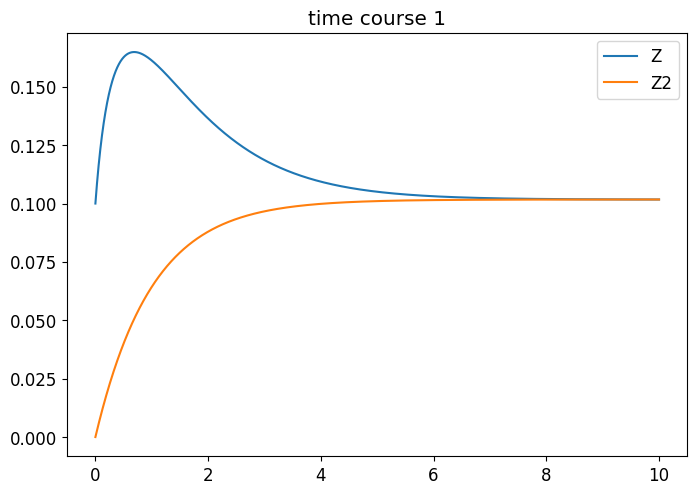

0.10173038109398488


In [9]:
I_FFL = """

r3: -> Y, k3*X/(Kxy+X)
r4: Y ->, k4*Y
r5: -> Z, k5*(Kzy/(Kzy+Y))*(X/(Kzx+X))
r6: Z ->, k6*Z
r7: -> Z2,k7
r8: Z2 ->,k8*Z2


Sx = 1
k1 = 1
k2 = 1
k3 = 1.5
k4 = 1
k5 = 1
k6 = 1
k7 = 0.10173511854721973
k8 = 1
Kxy = 0.5
Kzx = 0.5
Kzy = 0.18
X=1
init: (Y=0.1,Z=0.1)

!! Z Z2
"""

model = read_model(I_FFL).solve(tf=10,npoints=10000)
#model_2 = read_model(script(I_FFL,'k2',4)).solve(tf=10,npoints=10000)
model.plot()
plt.show()
print(model[1][-1])

# Stochastic Modeling

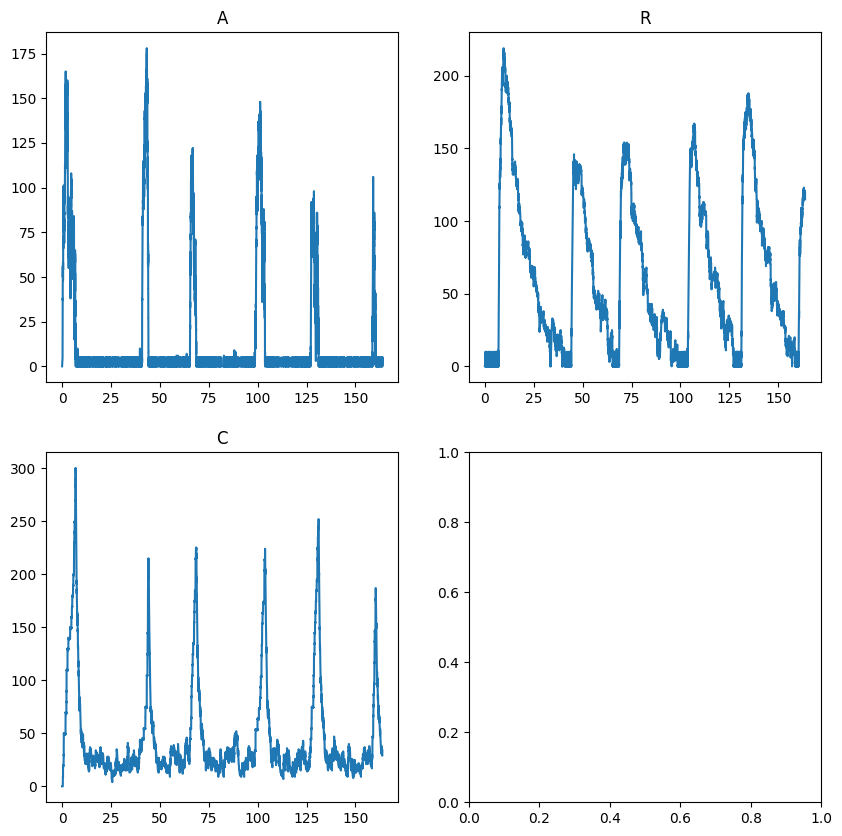

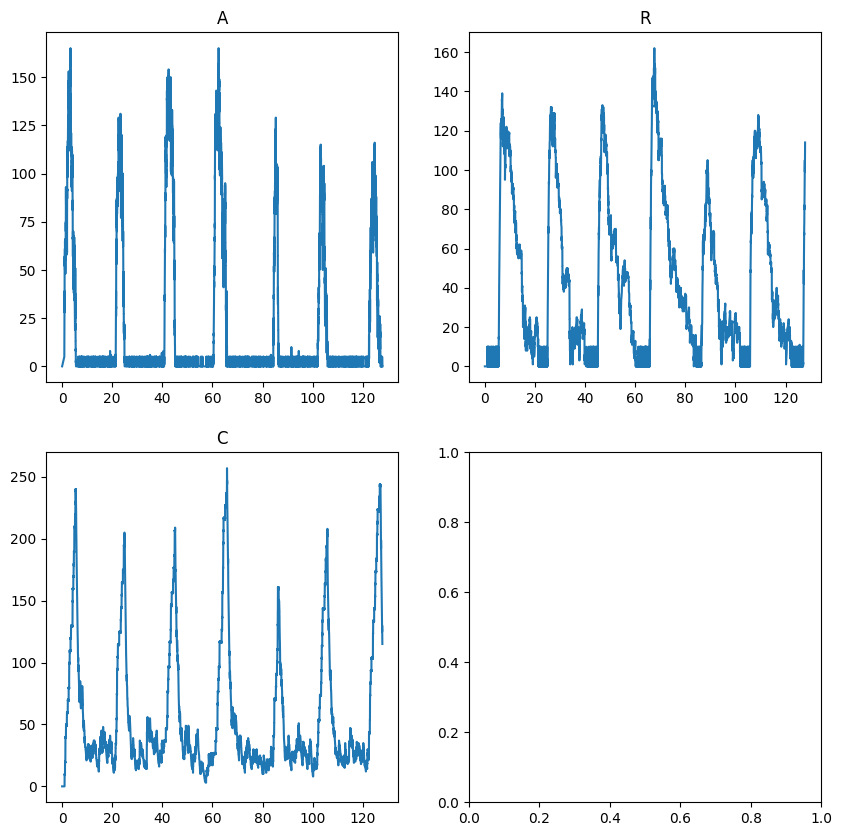

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate propensities
def prop_calc(var, parameters):
    A, R, C = var
    gA, bA, KA, a0, dA, gR, bR, KR, kC, dR = parameters
    
    p = np.zeros(6)
    p[0] = (gA / bA) * (a0 + A / KA) / (1 + A / KA)
    p[1] = (gR / bR) * (A / KR) / (1 + A / KR)
    p[2] = dA * A
    p[3] = dR * R
    p[4] = kC * A * R
    p[5] = dA * C
    
    return p

# Function to compute next time and state stochastically
def gillespies(t, var, S, parameters):
    p = prop_calc(var, parameters)
    deltat = np.random.exponential(scale=1 / sum(p))
    cump = np.cumsum(p) / sum(p) # take the cumulative sum of the propensities
    nextr = np.sum(cump < np.random.uniform(0, 1)) # evaluate the sampled number for the cumulative distribution
    newt = t + deltat # update the time value
    newvar = var + S[nextr] # update the reaction sequence
    newvar[newvar < 0] = 0
    return newt, newvar

# Parameters
parameters = (250, 5, 0.5, 0.1, 1, 50, 10, 1, 200, 0.1)

# Stoichiometry matrix
s = [[5,0,0],
     [0,10,0],
     [-1,0,0],
     [0,-1,0],
     [-1,-1,1],
     [0,1,-1]]

S = np.array(s)

# Simulation of 20000 events
t = np.zeros(20000)
var = np.array([0, 0, 0])
varmat = np.zeros((20000, 3))
varmat[0, :] = var # add the initial value inside the initiated matrix

for i in range(19999):
    t[i + 1], var = gillespies(t[i], var, S, parameters) # add the new time into the time vector for further timecourse
    varmat[i + 1, :] = var # add the new state vector into the timecourse matrix

# Plotting the results
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(t, varmat[:, 0])
axs[0, 0].set_title('A')
axs[0, 1].plot(t, varmat[:, 1])
axs[0, 1].set_title('R')
axs[1, 0].plot(t, varmat[:, 2])
axs[1, 0].set_title('C')

plt.show()

# Stochastic with dR = 0.2
parameters = (250, 5, 0.5, 0.1, 1, 50, 10, 1, 200, 0.2)

t = np.zeros(20000)
var = np.array([0, 0, 0])
varmat = np.zeros((20000, 3))
varmat[0, :] = var

for i in range(19999):
    t[i + 1], var = gillespies(t[i], var, S, parameters)
    varmat[i + 1, :] = var

# Plotting the results
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(t, varmat[:, 0])
axs[0, 0].set_title('A')
axs[0, 1].plot(t, varmat[:, 1])
axs[0, 1].set_title('R')
axs[1, 0].plot(t, varmat[:, 2])
axs[1, 0].set_title('C')

plt.show()

# Other codes

## To remember

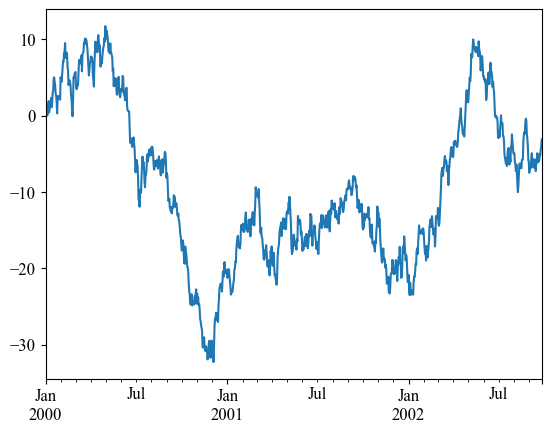

In [10]:
df2 = pd.DataFrame(
    {
        "A": 1.0,
        "B": pd.Timestamp("20130102"),
        "C": pd.Series(1, index=list(range(4)), dtype="float32"),
        "D": np.array([3] * 4, dtype="int32"),
        "E": pd.Categorical(["test", "train", "test", "train"]),
        "F": "foo",
    }
)

pd.Series(10,list("abcdef")).to_numpy()

ts = pd.Series(np.random.randn(1000), index=pd.date_range("1/1/2000", periods=1000))

ts = ts.cumsum()

ts.plot()
plt.show()

# System Biology Project

In [4]:
def parameter_extraction(model:str):
        parameters = {}
        for line in model.split('\n'):
            if '=' in line and 'init' not in line and '~' not in line:
                parm_value = line.split('=')
                parameter = parm_value[0].strip()
                value = float(parm_value[-1].strip())
                parameters[parameter] = value
        return parameters

class SteadyState:
    all = []
    def __init__(self,model:str,change={},tf=1000,npoints=1000,outputs=[],scan=False): # A constructor that is used to insert instance variables (i.e., variables that are particular to the created object)
        for line in model.split('\n'):
            if "title" in line:
                title = line.strip('title').strip()
        print(f"Processing {title}...")
        assert type(model) == str, f'Model {model} is not a string!'
        self.simtime = tf
        self.resolution = npoints
        self.parmchange = change
        self.model = model
        self.outputs = outputs
        self.parameters = parameter_extraction(self.model)
        self.model_solve = read_model(model).solve(tf=tf,npoints=npoints,outputs=outputs) #Creates the "model" instance variable that is the solved model 
        if scan == True:
            self.scanparm = change
            self.model_scan = read_model(model).scan(change,tf=tf,npoints=npoints,outputs=outputs) #Creates the "model" instance variable that is the scanned model
        SteadyState.all.append(self)
        

    def __repr__(self):
        title = self.model.split('\n')
        emp_list = [element for element in title if len(element) > 1]
        value = emp_list[0]
        return value
    
    def steady_scan(self, lists, stimuli, sensibility=False):
        sa_values = {} # Empty dictionary for sensibility values 
        ss_values = {} # Empty dictionary for steady-state values
    #_________________________________________________________________________________________________________________________
    # The scan object is a result of applying the scan function to the model
    # The list required is a list containing a string with the variables to be analyzed
    # The stimuli list is a list contaning different percentage values of change for a paramter as to determine the sensibility of the system to that parameter
    # The sensibility term is an option so as to decide if the sensibility analysis will be performed
    #_________________________________________________________________________________________________________________________
        print("Sensibility analysis...")
        for variable in lists: # For a variable in a list containing all variables in strings
            for index in range(0, len(self.model_scan)): # For a number assigined to all tested conditions
                ss=self.model_scan[index][variable].tolist()[-1] # Iterates through each test condition and each variable, evaluating it's Steady-State (SS) value
                ss_values.update({variable+' '+str(index):ss})  # Adds this value to a dictionary
        if sensibility == True: # Condition to peform a sensibility analysis
            for variable in lists:
                for index in range(0,len(self.model_scan)):
                    ssn = ss_values[variable+' '+str(index)] #Steady-state in a specific condition
                    ss0 = ss_values[variable+' '+'0'] # Steady-state in the first "normal" condition
                    sa = ((ssn-ss0)/ss0)/((stimuli[index]-stimuli[0])/stimuli[0]) if index != 0 else None # Calculated sensibility change due to changes in a parameter (defined by the percentage change in this parameter, B)
                    sa_values.update({variable+' '+str(index):sa})
            return pd.DataFrame([ss_values, sa_values],index=['SS','SA']).transpose() # Creates a DataFrame from the SS values and the SA values for each variable in each tested condition
        else:
            return ss_values

    def response_rate_max(self,variables):
        # Variables: list of strings containing the variables from the model to be analyzed.
        split = str(self.model_solve).split('\n') #Transform he model results into a list of strings, each element of the list corresponding to a line fo the results (the results are shown in a DataFrame)
        df = []
        for v in variables: #For v in a list containing the variables
            values_plus = []
            for i in range(0,len(self.model_solve[v])-2): 
                x = self.model_solve[v][i+1] - self.model_solve[v][i]
                y = self.model_solve[v][i+2] - self.model_solve[v][i+1]
                if x > 0 and y < 0:
                    values_plus.append(self.model_solve[v][i+1])
            link = {v:values_plus}
            data = pd.DataFrame(link)
            #print(data)
            temp_max=[]
            for line in str(self.model_solve).split('\n'):
                for max in data[v].tolist():
                    if str(max) in line:
                        time = line.split(' ')[0]
                        temp_max.append(time)
            dafr = pd.DataFrame(temp_max,data[v].tolist(),['time ' + str(v)])
            dafr.index.name = 'Max Value'
            df.append(dafr)
        return df

    def response_rate_min(self,variables):
        # Variables: list of strings containing the variables from the model to be analyzed.
        split = str(self.model_solve).split('\n') #Transform he model results into a list of strings, each element of the list corresponding to a line fo the results (the results are shown in a DataFrame)
        df = []
        for v in variables: #For v in a list containing the variables
            values_minus = []
            for i in range(0,len(self.model_solve[v])-2): 
                x = self.model_solve[v][i+1] - self.model_solve[v][i]
                y = self.model_solve[v][i+2] - self.model_solve[v][i+1]
                if x < 0 and y > 0:
                    values_minus.append(self.model_solve[v][i+1])
            link = {v:values_minus}
            data = pd.DataFrame(link)
            temp_min=[]
            for line in str(self.model_solve).split('\n'):
                for max in data[v].tolist():
                    if str(max) in line:
                        time = line.split(' ')[0]
                        temp_min.append(time)
            dafr = pd.DataFrame(temp_min,data[v].tolist(),['time ' + str(v)])
            dafr.index.name = 'Max Value'
            df.append(dafr)
        return df
    
    def script(self,k,value,dependent=False):
        cut=self.model.split('\n')
        #cut[0] = cut[0] + str(k)
        for line in cut:
            if 'title' in line:
                cut[cut.index(line)] = line + ' ' + str(k) + '=' + str(value)
            if str(k) in line and ',' not in line:
                replace = line.split('=')
                replace[-1]=str(value)
                new = ' = '.join(replace)
                cut[cut.index(line)] = new
                final = '\n'.join(cut)
                return SteadyState(final,tf=self.simtime,change=self.parmchange,npoints=self.resolution,outputs=self.outputs,scan=True)
            if dependent == True:
                if 'init' in line:
                    dep_variable = line.split(':')[-1].split(')')[0].split(',')
                    for variable in dep_variable:
                        if str(k) in variable:
                            var_to_change = variable.split('=')
                            var_to_change[-1] = str(value)
                            dep_variable[dep_variable.index(variable)]='='.join(var_to_change)
                    cut[cut.index(line)] = 'init: ' + ','.join(dep_variable) + ')'
                    final = '\n'.join(cut)
                    return SteadyState(final,tf=self.simtime,change=self.parmchange,npoints=self.resolution,outputs=self.outputs,scan=True)
    

## Monocyte Model - Series 0

#### General Model Analysis

In [5]:
monocyte_model = """

title Monocyte Model Series 0

r1: -> STAT1, (a1*(1/(1+(K1/STAT1)**n1)) + S1)*(1/(1+(STAT6/P2)**l2)) + b1
r2: STAT1 ->, q1*STAT1
r3: -> STAT6, a2*(1/(1+(K2/STAT6)**n2))+S2*(1/(1+(STAT1/P1)**l1)) + b2
r4: STAT6 ->, q2*STAT6

a1 = 5
a2 = 5
K1 = 1
K2 = 1
P1 = 0.5
P2 = 1
n1 = 6
n2 = 6
l1 = 1
l2 = 1
b1 = 0.05
b2 = 0.05
q1 = 5
q2 = 5
S1 = 3.75
S2 = 3.75

~ ratio = STAT1/STAT6

init:(STAT1=1.2,STAT6=2)
"""

monocyte_model_read = read_model(monocyte_model).solve(tf = 40, npoints=10000,outputs=['STAT1','STAT6','ratio'])
STAT1ss = monocyte_model_read[0][-1]
STAT6ss = monocyte_model_read[1][-1]

print(f"STAT1 steady state is {STAT1ss} and STAT6 steady state is {STAT6ss}")

# Sensibility analysis

parameter_to_scan = 'K1' # <-- ... change the parameter to inspect here
parameters = parameter_extraction(monocyte_model) # fetch the parameters of the model

# get the required parameter value and define specific changes
scan_param = parameters[parameter_to_scan] 
change = [scan_param,scan_param*(1-0.01),scan_param*(1-0.05),scan_param*(1-0.1),scan_param*(1-0.15),scan_param*(1-0.2)]

model = ss.SteadyState(monocyte_model,change={parameter_to_scan:change},tf=40,npoints=10000,scan=True,outputs=['STAT1','STAT6','ratio']) 

model.steady_scan(['ratio'],change,sensibility=True)

STAT1 steady state is 0.5951801713247082 and STAT6 steady state is 0.35438639579111436
Processing Monocyte Model Series 0...
Sensibility analysis...


100%|██████████| 6/6 [00:00<00:00, 1562.61it/s]


,SS,SA
ratio 0,1.679467,NaN
ratio 1,1.694671,-0.905327
ratio 2,1.791954,-1.339560
ratio 3,6.807273,-30.532349
ratio 4,6.974018,-21.016795
ratio 5,7.086206,-16.096595


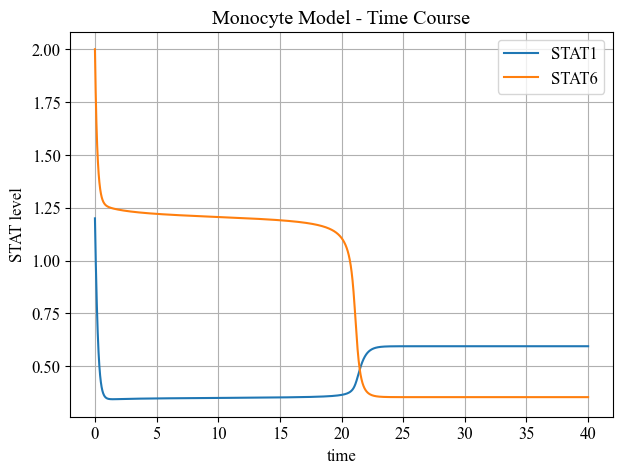

0.35438639579111436

In [6]:
f, ax = plt.subplots(1,1,figsize=(7,5))
time = model.model_solve.t
stat1 = model.model_solve['STAT1']
stat6 = model.model_solve['STAT6']

ax.plot(time,stat1,label='STAT1')
ax.plot(time,stat6,label='STAT6')
plt.title('Monocyte Model - Time Course')
plt.ylabel('STAT level')
plt.xlabel('time')
plt.grid(True)
plt.legend()
plt.show()

monocyte_model_read['STAT6'][-1]

[0.5951801713038817, 0.3543863958036694]


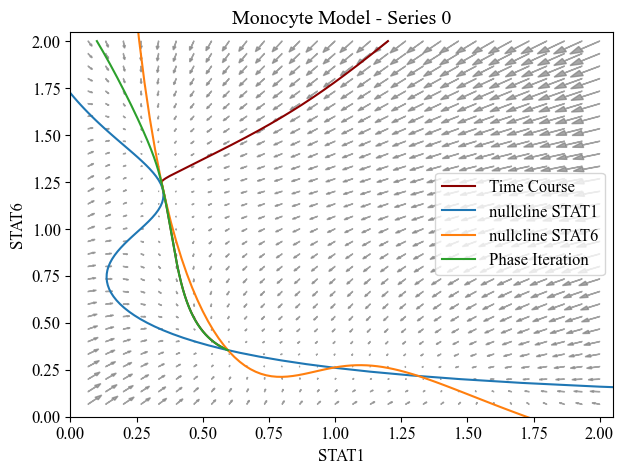

In [8]:
def model(t,state,parameter):
    V0 = (parameter['a1']*(1/(1+(parameter['K1']/state['STAT1'])**parameter['n1'])) + parameter['S1'])*(1/(1+(state['STAT6']/parameter['P2'])**parameter['l2'])) + parameter['b1']
    V1 = parameter['q1']*state['STAT1']
    V2 = parameter['a2']*(1/(1+(parameter['K2']/state['STAT6'])**parameter['n2']))+parameter['S2']*(1/(1+(state['STAT1']/parameter['P1'])**parameter['l1'])) + parameter['b2']
    V3 = parameter['q2']*state['STAT6']

    dSTAT1 = V0 - V1  
    dSTAT6 = V2 - V3
    return np.array([dSTAT1,dSTAT6])

parameter = parameter_extraction(script(monocyte_model,'S1',3.75))

intervali = [0,20]
intervalj = [0,20]
size = 31

rate_record = pd.DataFrame()
for x in np.linspace(intervali[0],intervali[1],size)[1:]: # set the points in the phase plot for one of the parameters
    for y in np.linspace(intervalj[0],intervalj[1],size)[1:]: # set the points for the other parameter
        state = {
            'STAT1':x/10,
            'STAT6':y/10
        }
        vector = model(0,state,parameter)
        norm_vector = vector*0.01 # normalize the rate vector for dS2
        record = pd.DataFrame({ # add the information into a df
            'State 1':state['STAT1'],
            'State 2':state['STAT6'],
            'Rate 1':norm_vector[0],
            'Rate 2':norm_vector[1]
                }, index = [0])
        rate_record = pd.concat([rate_record,record],ignore_index=True)

# Find nullcines
y_nullcline = np.linspace(0,2,101)[1:]
nullcline_STAT1 = (((parameter['S2']/((parameter['q2']*y_nullcline - parameter['a2']*(1/(1+(parameter['K2']/y_nullcline)**parameter['n2'])) - parameter['b2'])))-1)**(1/parameter['l1']))*parameter['P1']
nullcline_STAT6 = ((((parameter['a1']*(1/(1+(parameter['K1']/y_nullcline)**parameter['n1'])) + parameter['S1'])/(parameter['q1']*y_nullcline-parameter['b1']))-1)**parameter['l2'])*parameter['P2']

#____________________________________________________Phase Space Scanning____________________________________________________
# Define model based on the stated equations
def model(state,parameter):
    V0 = (parameter['a1']*(1/(1+(parameter['K1']/state[0])**parameter['n1'])) + parameter['S1'])*(1/(1+(state[1]/parameter['P2'])**parameter['l2'])) + parameter['b1']
    V1 = parameter['q1']*state[0]
    V2 = parameter['a2']*(1/(1+(parameter['K2']/state[1])**parameter['n2']))+parameter['S2']*(1/(1+(state[0]/parameter['P1'])**parameter['l1'])) + parameter['b2']
    V3 = parameter['q2']*state[1]

    dSTAT1 = V0 - V1
    dSTAT6 = V2 - V3
    return np.array([dSTAT1,dSTAT6])

#____________________________________________________Phase Space Scanning____________________________________________________
# Define model based on the stated equations
def model(state,parameter):
    V0 = (parameter['a1']*(1/(1+(parameter['K1']/state[0])**parameter['n1'])) + parameter['S1'])*(1/(1+(state[1]/parameter['P2'])**parameter['l2'])) + parameter['b1']
    V1 = parameter['q1']*state[0]
    V2 = parameter['a2']*(1/(1+(parameter['K2']/state[1])**parameter['n2']))+parameter['S2']*(1/(1+(state[0]/parameter['P1'])**parameter['l1'])) + parameter['b2']
    V3 = parameter['q2']*state[1]

    dSTAT1 = V0 - V1
    dSTAT6 = V2 - V3
    return np.array([dSTAT1,dSTAT6])

initial_position=[0.1,2]
final_time=40
time_interval = 0.01
total_interations = final_time*(1/time_interval)+1
# Define initial position, time range and time iteration
positions = [np.array([initial_position[0],initial_position[1]])]
total_interations = final_time*(1/time_interval)+1
for i in range(0,int(total_interations)):
    next_position = positions[i] + model(positions[i],parameter)*time_interval
    positions.append(next_position)


STAT1 = [array[0] for array in positions]
STAT6 = [array[1] for array in positions]

STAT1 = [array[0] for array in positions]
STAT6 = [array[1] for array in positions]

print(list(positions[-1]))

#____________________________________________________________________________________________________________________________
    
plt.figure(figsize=(7,5))
for idx, row in rate_record.iterrows(): # interates through the rows of a df unfolding the index from them
    plt.arrow(
                row['State 1'], 
                row['State 2'], 
                row['Rate 1'], 
                row['Rate 2'],
                head_width=0.4*(row['Rate 1']**2+row['Rate 2']**2)**(1/2), 
                head_length=0.6*(row['Rate 1']**2+row['Rate 2']**2)**(1/2),
                fc='grey', 
                ec='grey',
                alpha=0.7,
                linestyle='-'
                )

plt.plot(monocyte_model_read[0],
         monocyte_model_read[1],
         color='darkred',
         label='Time Course')

plt.plot(nullcline_STAT1,
         y_nullcline,
         label='nullcline STAT1')
plt.plot(y_nullcline,
         nullcline_STAT6,
         label='nullcline STAT6')
plt.plot(STAT1,
         STAT6,
         label='Phase Iteration')
plt.title('Monocyte Model - Series 0')
plt.xlim(0,2.05)
plt.ylim(0,2.05)
plt.xlabel('STAT1')
plt.ylabel('STAT6')
#plt.xticks([0,0.5,1,1.5,2])
#plt.yticks([0,0.5,1,1.5,2])
plt.legend()
plt.show()


### Find the basins of attraction for each steady state

In [5]:
# Define the amount of points to map in the phase space
intervali = [0,20]
intervalj = [0,20]
size = 31

paramete = parameter_extraction(monocyte_model)

total_time = 40
time_interval = 0.01
total_iterations = total_time/time_interval + 1

# Iterate over the phase space to determine the steady state of each point
basin_of_attraction = []
for x in np.linspace(intervali[0],intervali[1],size)[1:]: # set the points in the phase plot for one of the parameters
    for y in np.linspace(intervalj[0],intervalj[1],size)[1:]: # set the points for the other parameter
        state = [x/10,y/10]
        positions_course = [np.array(state)]
        # Create a time course based on vector field of the phase space
        for i in range(0,int(total_iterations)):
            next_position = positions_course[i] + model(positions_course[i],parameter)*time_interval # Sum of a position vector plus the position variation, v + Dv*t
            positions_course.append(next_position)
        rounded_position = [round(num, 3) for num in positions_course[-1]]
        # Classify according to the steady state
        basin_of_attraction.append([state,"red"]) if rounded_position == [0.595, 0.354] else basin_of_attraction.append([state,"blue"])

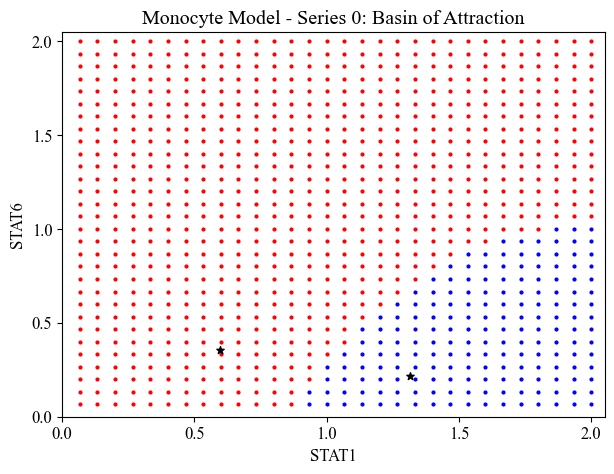

In [6]:
plt.figure(figsize=(7,5))
#plt.plot(nullcline_STAT1,y_nullcline,label='nullcline STAT1')
#plt.plot(y_nullcline,nullcline_STAT6,label='nullcline STAT6')
for state in basin_of_attraction:
    plt.scatter(state[0][0],state[0][1],color=state[-1],s=4)
plt.scatter(x = [1.315294711041883,0.5951801713038596],
             y = [0.21668151419518886,0.3543863958036817],
             color='black',
             s=30,
             marker='*')
plt.title('Monocyte Model - Series 0: Basin of Attraction')
plt.xlim(0,2.05)
plt.ylim(0,2.05)
plt.xlabel('STAT1')
plt.ylabel('STAT6')
plt.xticks([0,0.5,1,1.5,2])
plt.yticks([0,0.5,1,1.5,2])
plt.show()

### Sensibility Analysis

#### Local Sensibility

In [8]:
# Sensibility analysis
sensibility = dict()
sensibility_df = pd.DataFrame()
parameters = parameter_extraction(monocyte_model) # fetch the parameters of the model
for parameter in parameters.keys():
    print(f"Processing {len(parameters.keys())} parameters")
    parameter_to_scan = parameter 

    # get the required parameter value and define specific changes
    scan_param = parameters[parameter_to_scan] 
    change = [scan_param,scan_param*(1-0.01),scan_param*(1-0.02),scan_param*(1-0.03),scan_param*(1-0.04),scan_param*(1-0.05)]

    model = ss.SteadyState(monocyte_model,
                        change={parameter_to_scan:change},
                        tf=40,
                        npoints=10000,
                        scan=True,
                        outputs=['STAT1','STAT6','ratio']) 
    df = model.steady_scan(['ratio'],change,sensibility=True)
    
    # Calculate the average and stdv of sensibility values for each parameter
    sa_average = np.mean(df['SA'].dropna().tolist())
    sa_stdv = np.std(df['SA'].dropna().tolist())
    sensibility[parameter] = [sa_average,sa_stdv]

    # Summirize global results in an annotated detaframe
    index = df.index
    ss_column = df['SS']
    sa_column = df['SA']
    to_df = {f"SS {parameter}":ss_column,f"SA {parameter}":sa_column}
    final_df = pd.DataFrame(to_df,index=index)
    sensibility_df = pd.concat([sensibility_df,final_df],axis=1)


Processing 16 parameters
Processing Monocyte Model Series 0...
Sensibility analysis...


100%|██████████| 6/6 [00:00<00:00, 1436.24it/s]

Processing 16 parameters
Processing Monocyte Model Series 0...


Sensibility analysis...


100%|██████████| 6/6 [00:00<00:00, 1926.94it/s]

Processing 16 parameters
Processing Monocyte Model Series 0...


Sensibility analysis...


100%|██████████| 6/6 [00:00<?, ?it/s]

Processing 16 parameters
Processing Monocyte Model Series 0...


Sensibility analysis...


100%|██████████| 6/6 [00:00<?, ?it/s]

Processing 16 parameters
Processing Monocyte Model Series 0...


Sensibility analysis...


100%|██████████| 6/6 [00:00<00:00, 847.99it/s]

Processing 16 parameters
Processing Monocyte Model Series 0...


Sensibility analysis...


100%|██████████| 6/6 [00:00<?, ?it/s]

Processing 16 parameters
Processing Monocyte Model Series 0...


Sensibility analysis...


100%|██████████| 6/6 [00:00<?, ?it/s]

Processing 16 parameters
Processing Monocyte Model Series 0...


Sensibility analysis...


100%|██████████| 6/6 [00:00<00:00, 1242.14it/s]

Processing 16 parameters
Processing Monocyte Model Series 0...


Sensibility analysis...


100%|██████████| 6/6 [00:00<00:00, 5217.88it/s]

Processing 16 parameters
Processing Monocyte Model Series 0...


Sensibility analysis...


100%|██████████| 6/6 [00:00<00:00, 5667.98it/s]

Processing 16 parameters
Processing Monocyte Model Series 0...


Sensibility analysis...


100%|██████████| 6/6 [00:00<00:00, 5003.15it/s]

Processing 16 parameters
Processing Monocyte Model Series 0...


Sensibility analysis...


100%|██████████| 6/6 [00:00<00:00, 566.29it/s]


Processing 16 parameters
Processing Monocyte Model Series 0...
Sensibility analysis...


100%|██████████| 6/6 [00:00<00:00, 2163.13it/s]

Processing 16 parameters
Processing Monocyte Model Series 0...


Sensibility analysis...


100%|██████████| 6/6 [00:00<00:00, 1919.74it/s]

Processing 16 parameters
Processing Monocyte Model Series 0...


Sensibility analysis...


100%|██████████| 6/6 [00:00<00:00, 1493.52it/s]

Processing 16 parameters
Processing Monocyte Model Series 0...


Sensibility analysis...


100%|██████████| 6/6 [00:00<00:00, 2803.05it/s]


In [9]:
sensibility_df

,SS a1,SA a1,SS a2,SA a2,SS K1,SA K1,SS K2,SA K2,SS P1,SA P1,...,SS b2,SA b2,SS q1,SA q1,SS q2,SA q2,SS S1,SA S1,SS S2,SA S2
ratio 0,1.679467,NaN,1.679467,NaN,1.679467,NaN,1.679467,NaN,1.679467,NaN,...,1.679467,NaN,1.679467,NaN,1.679467,NaN,1.679467,NaN,1.679467,NaN
ratio 1,1.677027,0.145278,1.679633,-0.009882,1.694671,-0.905327,0.264920,84.225925,1.695295,-0.942427,...,1.680307,-0.050025,1.728279,-2.906435,0.259553,84.545490,0.277681,83.466112,1.708596,-1.734435
ratio 2,1.674620,0.144280,1.679799,-0.009879,1.712453,-0.982034,0.256117,42.375053,1.711535,-0.954703,...,1.681148,-0.050048,1.782474,-3.066659,0.246460,42.662555,0.269456,41.977922,1.738498,-1.757428
ratio 3,1.672247,0.143302,1.679964,-0.009875,1.733613,-1.074671,0.250219,28.367103,1.728204,-0.967316,...,1.681990,-0.050070,1.843805,-3.261711,0.236528,28.638836,0.262887,28.115675,1.769209,-1.781165
ratio 4,1.669904,0.142342,1.680130,-0.009872,1.759403,-1.189907,0.245749,21.341865,1.745321,-0.980282,...,1.682832,-0.050093,1.915241,-3.509656,0.228184,21.603320,0.257094,21.172984,1.800770,-1.805686
ratio 5,1.667593,0.141400,1.680295,-0.009869,1.791954,-1.339560,0.242158,17.116257,1.762904,-0.993617,...,1.683675,-0.050115,2.002593,-3.847961,0.220838,17.370146,0.251784,17.001619,1.833225,-1.831033


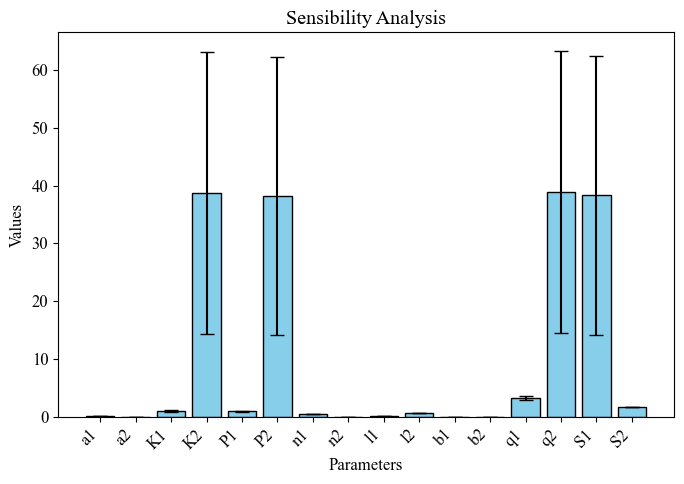

In [11]:
data = sensibility

# Separate the keys, averages, and standard deviations
variables = list(data.keys())
averages = [abs(data[var][0]) for var in variables]
std_devs = [data[var][1] for var in variables]

# Plotting
fig, ax = plt.subplots(figsize=(7, 5))

# Create bar plot with error bars
ax.bar(variables, averages,yerr=std_devs, capsize=5, color='skyblue', edgecolor='black') 

# Adding labels and title
ax.set_xlabel('Parameters')
ax.set_ylabel('Values')
ax.set_title('Sensibility Analysis')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show plot
plt.show()

#### Global Sobol's Sensibility

In [55]:
from SALib.sample import saltelli
from SALib.analyze import sobol

parameters = parameter_extraction(monocyte_model)

# define the variable space to randomize
problem = {
    'num_vars':len(parameters),
    'names':list(parameters.keys())
    }

bounds = []
for param in parameters.values():
    interval_p = param + 0.15*param
    interval_m = param - 0.15*param
    int_list = [interval_m,interval_p]
    bounds.append(int_list)

problem['bounds'] = bounds

# randomize inputs through a sample function
param_values = saltelli.sample(problem, 2**13)

C:\Users\jpedr\AppData\Local\Temp\ipykernel_21688\3667772173.py:22: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 2**13)


In [33]:
# Define the model
def model(state, t, parameters):
    x1, x2 = state
    a1, a2, K1, K2, p1, p2, n1, n2, l1, l2, b1, b2, q1, q2, s1, s2 = parameters
    
    # Equations of the model
    v1 = (a1*(1/(1+(K1/x1)**n1))+s1)*(1/(1+(x2/p2)**l2))+b1
    v2 = q1*x1
    v3 = a2*(1/(1+(K2/x2)**n2))+s2*(1/(1+(x1/p1)**l1))+b2
    v4 = q2*x2
    
    dX1 = v1 - v2
    dX2 = v3 - v4
    
    return [dX1, dX2]

# Model definitions
state = [1.2,2]
times = np.linspace(0, 40, 40001)
solution = odeint(model, y0=state, t=times, args=(parameters.values(),))
print(solution[-1][0]/solution[-1][1])

# Solve model for each parameter sample
model_parse = np.zeros((param_values.shape[0],3))
for row in tqdm(range(0,len(param_values))):
    param_set = list(param_values[row,:])
    solution = odeint(model, state, t=times, args=(param_set,))
    sd_state = solution[-1]
    model_parse[row][0] = sd_state[0]
    model_parse[row][1] = sd_state[1]
    model_parse[row][2] = sd_state[0]/sd_state[1]

1.6794667582992577


100%|██████████| 278528/278528 [10:02<00:00, 462.32it/s]


In [34]:
# determine sentivity indeces 
Si = sobol.analyze(problem,model_parse[:,2])

c:\Users\jpedr\anaconda3\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


[0.00619905 0.02408299 0.03435775 0.05392627 0.01040278 0.00973152
 0.00065303 0.00395609 0.00546537 0.00991359 0.00064099 0.00054179
 0.1457865  0.13860284 0.05510238 0.0545164 ]


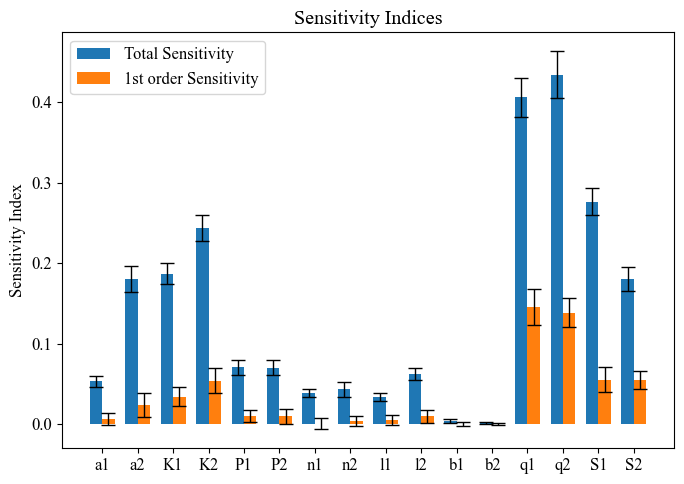

In [51]:
error_kw = {'elinewidth': 2, 'ecolor': 'black', 'capsize': 5, 'capthick': 1}

# Create subplots
f, ax = plt.subplots(1,1, figsize=(7, 5))

# Define the positions for the bars
x = np.arange(len(problem['names']))

width = 0.35  # Width of the bars

# Error bar settings
error_kw = dict(ecolor='black', lw=1, capsize=5, capthick=1)

# Plot the data sets
bar1 = ax.bar(x - width/2, Si['ST'], width, yerr=Si['ST_conf'], error_kw=error_kw, label='Total Sensitivity')
bar2 = ax.bar(x + width/2, Si['S1'], width, yerr=Si['S1_conf'], error_kw=error_kw, label='1st order Sensitivity')

ax.set_title('Sensitivity Indices')
ax.set_ylabel('Sensitivity Index')
ax.set_xticks(x)
ax.set_xticklabels(problem['names'])
ax.legend()

plt.tight_layout()
plt.show()

## Monocoyte Model - Seires 1

### General Model Analysis

In [8]:
# Change previous model
monocyte_model_1 = script(script(monocyte_model,'S2',4),'S1',4)

# Read new model
monocyte_model_1_read = read_model(monocyte_model_1).solve(tf = 40, npoints=10000)
monocyte_model_1_read2 = read_model(script(script(monocyte_model_1,'STAT1',0.8,True),'STAT6',0.4,True)).solve(tf = 40, npoints=10000)
monocyte_model_1_read3 = read_model(script(script(monocyte_model_1,'STAT1',1.4,True),'STAT6',0.3,True)).solve(tf = 40, npoints=10000)
# Find steady state values for both variables
STAT1ss = monocyte_model_1_read[0][-1]
STAT6ss = monocyte_model_1_read[1][-1]

print(f"STAT1 steady state is {STAT1ss} and STAT6 steady state is {STAT6ss}")
print(f"STAT1 steady state is {monocyte_model_1_read2[0][-1]} and STAT6 steady state is {monocyte_model_1_read2[1][-1]}")
print(f"STAT1 steady state is {monocyte_model_1_read3[0][-1]} and STAT6 steady state is {monocyte_model_1_read3[1][-1]}")


STAT1 steady state is 0.35646379456275035 and STAT6 steady state is 1.3149529950900753
STAT1 steady state is 1.3768645784630786 and STAT6 steady state is 0.22324517314319264
STAT1 steady state is 1.3768645784641949 and STAT6 steady state is 0.22324517314298317


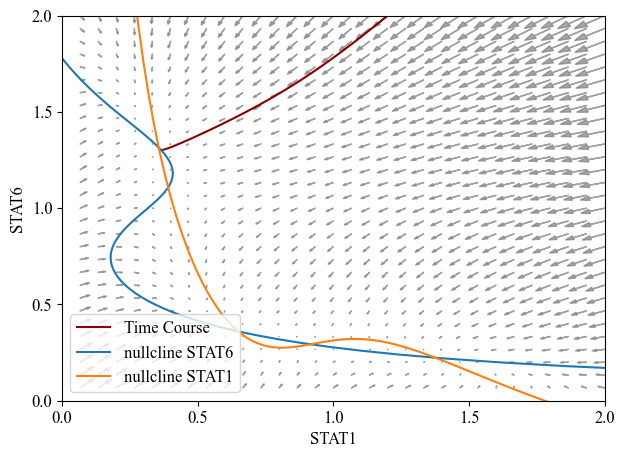

In [8]:
# Define model based on the stated equations
def model(state,parameter):
    V0 = (parameter['a1']*(1/(1+(parameter['K1']/state['STAT1'])**parameter['n1'])) + parameter['S1'])*(1/(1+(state['STAT6']/parameter['P2'])**parameter['l2'])) + parameter['b1']
    V1 = parameter['q1']*state['STAT1']
    V2 = parameter['a2']*(1/(1+(parameter['K2']/state['STAT6'])**parameter['n2']))+parameter['S2']*(1/(1+(state['STAT1']/parameter['P1'])**parameter['l1'])) + parameter['b2']
    V3 = parameter['q2']*state['STAT6']

    dSTAT1 = V0 - V1
    dSTAT6 = V2 - V3
    return np.array([dSTAT1,dSTAT6])

# Extract parameters from the input
parameter = parameter_extraction(monocyte_model_1)

intervali = [0,20]
intervalj = [0,20]
size = 31

# Calculate phase space from the model
rate_record = pd.DataFrame()
for x in np.linspace(intervali[0],intervali[1],size)[1:]: # set the points in the phase plot for one of the parameters
    for y in np.linspace(intervalj[0],intervalj[1],size)[1:]: # set the points for the other parameter
        state = {
            'STAT1':x/10,
            'STAT6':y/10
        }
        vector = model(state,parameter)
        norm_vector = vector*0.01*np.linalg.norm(vector)*(1/np.linalg.norm(vector)) # normalize the rate vector for dS2
        record = pd.DataFrame({ # add the information into a df
            'State 1':state['STAT1'],
            'State 2':state['STAT6'],
            'Rate 1':norm_vector[0],
            'Rate 2':norm_vector[1]
                }, index = [0])
        rate_record = pd.concat([rate_record,record],ignore_index=True)

# Find nullcines
y = np.linspace(0,2,101)[1:]
nullcline_STAT6 = (((parameter['S2']/((parameter['q2']*y - parameter['a2']*(1/(1+(parameter['K2']/y)**parameter['n2'])) - parameter['b2'])))-1)**(1/parameter['l1']))*parameter['P1']
nullcline_STAT1 = ((((parameter['a1']*(1/(1+(parameter['K1']/y)**parameter['n1'])) + parameter['S1'])/(parameter['q1']*y-parameter['b1']))-1)**parameter['l2'])*parameter['P2']

# Plot phase space
plt.figure(figsize=(7,5))
for idx, row in rate_record.iterrows(): # interates through the rows of a df unfolding the index from them
    plt.arrow(row['State 1'], row['State 2'], row['Rate 1'], row['Rate 2'], head_width=0.4*(row['Rate 1']**2+row['Rate 2']**2)**(1/2), head_length=0.6*(row['Rate 1']**2+row['Rate 2']**2)**(1/2),fc='grey', ec='grey',alpha=0.7,linestyle='-')
plt.plot(monocyte_model_1_read[0],monocyte_model_1_read[1],color='darkred',label='Time Course')
plt.plot(nullcline_STAT6,y,label='nullcline STAT6')
plt.plot(y,nullcline_STAT1,label='nullcline STAT1')
#______________________________________________________________________________________
plt.xlim(0,2)
plt.ylim(0,2)
plt.xlabel('STAT1')
plt.ylabel('STAT6')
plt.xticks([0,0.5,1,1.5,2])
plt.yticks([0,0.5,1,1.5,2])
plt.legend()
plt.show()

### Find the basins of attraction for each steady state

In [9]:
# Define model based on the stated equations
def model(state,parameter):
    V0 = (parameter['a1']*(1/(1+(parameter['K1']/state[0])**parameter['n1'])) + parameter['S1'])*(1/(1+(state[1]/parameter['P2'])**parameter['l2'])) + parameter['b1']
    V1 = parameter['q1']*state[0]
    V2 = parameter['a2']*(1/(1+(parameter['K2']/state[1])**parameter['n2']))+parameter['S2']*(1/(1+(state[0]/parameter['P1'])**parameter['l1'])) + parameter['b2']
    V3 = parameter['q2']*state[1]

    dSTAT1 = V0 - V1
    dSTAT6 = V2 - V3
    return np.array([dSTAT1,dSTAT6])

# Define the amount of points to map in the phase space
intervali = [0,20]
intervalj = [0,20]
size = 51

parameter = parameter_extraction(monocyte_model_1)

total_time = 40
time_interval = 0.01
total_iterations = total_time/time_interval + 1

# Iterate over the phase space to determine the steady state of each point
basin_df = pd.DataFrame()
basin_of_attraction = []
for x in np.linspace(intervali[0],intervali[1],size)[1:]: # set the points in the phase plot for one of the parameters
    for y in np.linspace(intervalj[0],intervalj[1],size)[1:]: # set the points for the other parameter
        state = [x/10,y/10]
        positions_course = [np.array(state)]
        # Create a time course based on vector field of the phase space
        for i in range(0,int(total_iterations)):
            next_position = positions_course[i] + model(positions_course[i],parameter)*time_interval # Sum of a position vector plus the position variation, v + Dv*t
            positions_course.append(next_position)
        rounded_position = [round(num, 3) for num in positions_course[-1]]
        # Classify according to the steady state
        if rounded_position == [0.356, 1.315]:
            basin_of_attraction.append([state,"green"])
        elif rounded_position == [round(0.6495181240013972,3), round(0.36014934971456425,3)]:
            basin_of_attraction.append([state,"red"]) 
        else:
            basin_of_attraction.append([state,"blue"]) 

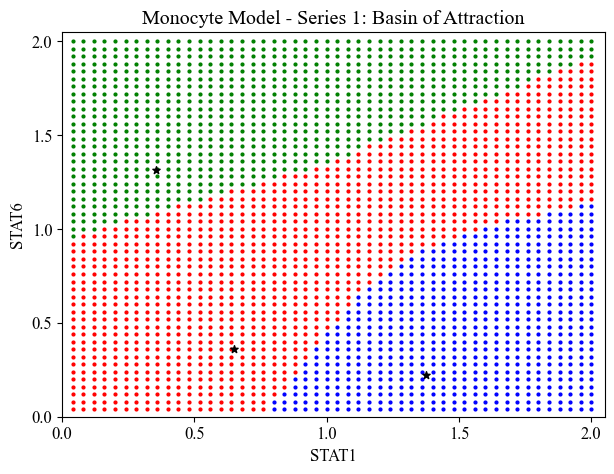

In [10]:
plt.figure(figsize=(7,5))
for state in basin_of_attraction:
    plt.scatter(state[0][0],state[0][1],color=state[-1],s=4)
plt.scatter(x = [monocyte_model_1_read[0][-1],monocyte_model_1_read2[0][-1],monocyte_model_1_read3[0][-1]],
             y = [monocyte_model_1_read[1][-1],monocyte_model_1_read2[1][-1],monocyte_model_1_read3[1][-1]],
             color='black',
             s=30,
             marker='*')
plt.title('Monocyte Model - Series 1: Basin of Attraction')
plt.xlim(0,2.05)
plt.ylim(0,2.05)
plt.xlabel('STAT1')
plt.ylabel('STAT6')
plt.xticks([0,0.5,1,1.5,2])
plt.yticks([0,0.5,1,1.5,2])
plt.show()

### Sensibility Analysis

In [13]:
from SALib.sample import saltelli
from SALib.analyze import sobol

parameters_1 = parameter_extraction(monocyte_model_1)

# define the variable space to randomize
problem = {
    'num_vars':len(parameters_1),
    'names':list(parameters_1.keys())
    }

bounds = []
for param in parameters_1.values():
    interval_p = param + 0.15*param
    interval_m = param - 0.15*param
    int_list = [interval_m,interval_p]
    bounds.append(int_list)

problem['bounds'] = bounds
print(parameters_1)
# randomize inputs through a sample function
param_values = saltelli.sample(problem, 2**13)

{'a1': 5.0, 'a2': 5.0, 'K1': 1.0, 'K2': 1.0, 'P1': 0.5, 'P2': 1.0, 'n1': 6.0, 'n2': 6.0, 'l1': 1.0, 'l2': 1.0, 'b1': 0.05, 'b2': 0.05, 'q1': 5.0, 'q2': 5.0, 'S1': 4.0, 'S2': 4.0}


C:\Users\jpedr\AppData\Local\Temp\ipykernel_41572\3989352156.py:22: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 2**13)


In [15]:
# Define the model
def model(state, t, parameters):
    x1, x2 = state
    a1, a2, K1, K2, p1, p2, n1, n2, l1, l2, b1, b2, q1, q2, s1, s2 = parameters
    
    # Equations of the model
    v1 = (a1*(1/(1+(K1/x1)**n1))+s1)*(1/(1+(x2/p2)**l2))+b1
    v2 = q1*x1
    v3 = a2*(1/(1+(K2/x2)**n2))+s2*(1/(1+(x1/p1)**l1))+b2
    v4 = q2*x2
    
    dX1 = v1 - v2
    dX2 = v3 - v4
    
    return [dX1, dX2]

# Model definitions
state = [1.2,2]
times = np.linspace(0, 40, 40001)

# Solve model for each parameter sample
model_parse_1 = np.zeros((param_values.shape[0],3))
for row in tqdm(range(0,len(param_values))):
    param_set = list(param_values[row,:])
    solution = odeint(model, state, t=times, args=(param_set,))
    sd_state = solution[-1]
    model_parse_1[row][0] = sd_state[0]
    model_parse_1[row][1] = sd_state[1]
    model_parse_1[row][2] = sd_state[0]/sd_state[1]

  0%|          | 0/278528 [00:00<?, ?it/s]

100%|██████████| 278528/278528 [22:17<00:00, 208.32it/s]


In [18]:
# determine sentivity indeces 
Si_1 = sobol.analyze(problem,model_parse_1[:,2])

c:\Users\jpedr\anaconda3\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


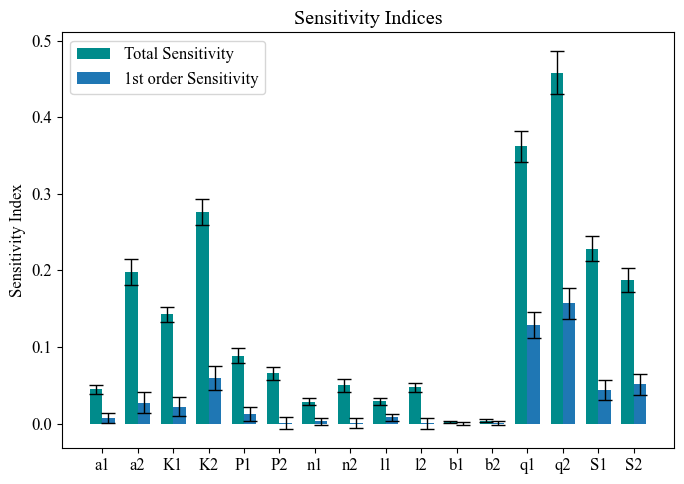

In [29]:
error_kw = {'elinewidth': 2, 'ecolor': 'black', 'capsize': 5, 'capthick': 1}

# Create subplots
f, ax = plt.subplots(1,1, figsize=(7, 5))

# Define the positions for the bars
x = np.arange(len(problem['names']))

width = 0.35  # Width of the bars

# Error bar settings
error_kw = dict(ecolor='black', lw=1, capsize=5, capthick=1)

# Plot the data sets
bar1 = ax.bar(x - width/2, Si_1['ST'], width, yerr=Si_1['ST_conf'], error_kw=error_kw, label='Total Sensitivity',color='darkcyan')
bar2 = ax.bar(x + width/2, Si_1['S1'], width, yerr=Si_1['S1_conf'], error_kw=error_kw, label='1st order Sensitivity')

ax.set_title('Sensitivity Indices')
ax.set_ylabel('Sensitivity Index')
ax.set_xticks(x)
ax.set_xticklabels(problem['names'])
ax.legend()

plt.tight_layout()
plt.show()

## Monocyte Model - Series 2

### General Model Analysis

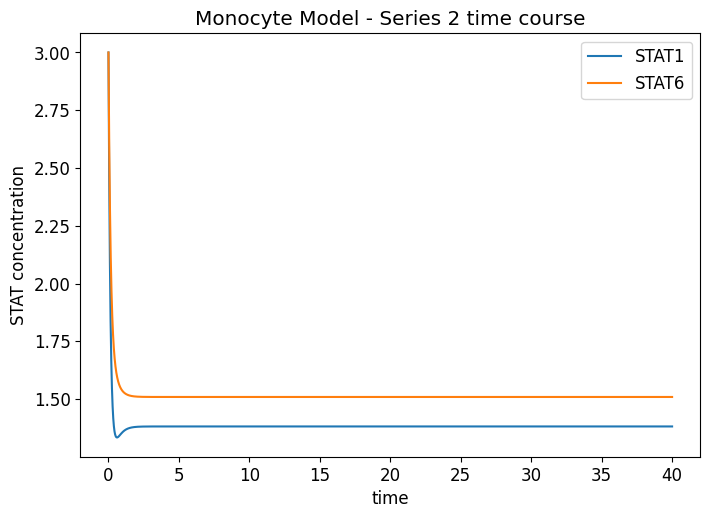

[3.061091107079053, 0.1296672499537007] [1.3819008593272952, 1.5094499079556472] [0.6258370685350513, 0.3968440471871608] [0.3066082239827218, 1.8929698937764996]


In [31]:
monocyte_model_2 = """
r1: -> STAT1, (a1*(1/(1+(K1/STAT1)**n1)) + S1)*(1/(1+(STAT6/P2)**l2)) + b1
r2: STAT1 ->, q1*STAT1
r3: -> STAT6, a2*(1/(1+(K2/STAT6)**n2))+S2*(1/(1+(STAT1/P1)**l1)) + b2
r4: STAT6 ->, q2*STAT6

a1 = 15
a2 = 8
K1 = 1
K2 = 1
P1 = 0.5
P2 = 1
n1 = 22
n2 = 6
l1 = 1
l2 = 1
b1 = 0.05
b2 = 0.05
q1 = 5.8
q2 = 5.8
S1 = 5
S2 = 5

init:(STAT1=2,STAT6=1)
"""

monocyte_read_model2 = read_model(monocyte_model_2).solve(tf=40,npoints=50000)
monocyte_read_model2_2 = read_model(script(script(monocyte_model_2,'STAT1',3,True),'STAT6',3,True)).solve(tf=40,npoints=50000)
monocyte_read_model2_3 = read_model(script(script(monocyte_model_2,'STAT1',0.8,True),'STAT6',0.8,True)).solve(tf=40,npoints=50000)
monocyte_read_model2_4 = read_model(script(script(monocyte_model_2,'STAT1',1,True),'STAT6',3,True)).solve(tf=40,npoints=50000)
monocyte_read_model2_2.plot()

ss1 = [monocyte_read_model2[0][-1],monocyte_read_model2[1][-1]]
ss2 = [monocyte_read_model2_2[0][-1],monocyte_read_model2_2[1][-1]]
ss3 = [monocyte_read_model2_3[0][-1],monocyte_read_model2_3[1][-1]]
ss4 = [monocyte_read_model2_4[0][-1],monocyte_read_model2_4[1][-1]]


plt.title('Monocyte Model - Series 2 time course')
plt.ylabel('STAT concentration')
plt.xlabel('time')
plt.show()
print(ss1,ss2,ss3,ss4)

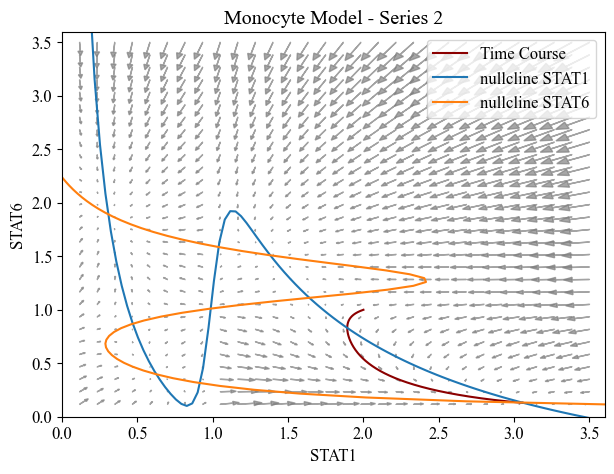

In [7]:
def model(t,state,parameter):
    V0 = (parameter['a1']*(1/(1+(parameter['K1']/state['STAT1'])**parameter['n1'])) + parameter['S1'])*(1/(1+(state['STAT6']/parameter['P2'])**parameter['l2'])) + parameter['b1']
    V1 = parameter['q1']*state['STAT1']
    V2 = parameter['a2']*(1/(1+(parameter['K2']/state['STAT6'])**parameter['n2']))+parameter['S2']*(1/(1+(state['STAT1']/parameter['P1'])**parameter['l1'])) + parameter['b2']
    V3 = parameter['q2']*state['STAT6']

    dSTAT1 = V0 - V1  
    dSTAT6 = V2 - V3
    return np.array([dSTAT1,dSTAT6])

parameter = parameter_extraction(monocyte_model_2)

intervali = [0,35]
intervalj = [0,35]
size = 31

rate_record = pd.DataFrame()
for x in np.linspace(intervali[0],intervali[1],size)[1:]: # set the points in the phase plot for one of the parameters
    for y in np.linspace(intervalj[0],intervalj[1],size)[1:]: # set the points for the other parameter
        state = {
            'STAT1':x/10,
            'STAT6':y/10
        }
        vector = model(0,state,parameter)
        norm_vector = vector*0.01 # normalize the rate vector for dS2
        record = pd.DataFrame({ # add the information into a df
            'State 1':state['STAT1'],
            'State 2':state['STAT6'],
            'Rate 1':norm_vector[0],
            'Rate 2':norm_vector[1]
                }, index = [0])
        rate_record = pd.concat([rate_record,record],ignore_index=True)

# Find nullcines
y_nullcline = np.linspace(0,3.6,101)[1:]
nullcline_STAT1 = (((parameter['S2']/((parameter['q2']*y_nullcline - parameter['a2']*(1/(1+(parameter['K2']/y_nullcline)**parameter['n2'])) - parameter['b2'])))-1)**(1/parameter['l1']))*parameter['P1']
nullcline_STAT6 = ((((parameter['a1']*(1/(1+(parameter['K1']/y_nullcline)**parameter['n1'])) + parameter['S1'])/(parameter['q1']*y_nullcline-parameter['b1']))-1)**parameter['l2'])*parameter['P2']

#____________________________________________________________________________________________________________________________
    
plt.figure(figsize=(7,5))
for idx, row in rate_record.iterrows(): # interates through the rows of a df unfolding the index from them
    plt.arrow(
                row['State 1'], 
                row['State 2'], 
                row['Rate 1'], 
                row['Rate 2'],
                head_width=0.4*(row['Rate 1']**2+row['Rate 2']**2)**(1/2), 
                head_length=0.5*(row['Rate 1']**2+row['Rate 2']**2)**(1/2),
                fc='grey', 
                ec='grey',
                alpha=0.7,
                linestyle='-'
                )

plt.plot(monocyte_read_model2[0],
         monocyte_read_model2[1],
         color='darkred',
         label='Time Course')
plt.plot(y_nullcline,
         nullcline_STAT6,
         label='nullcline STAT1')
plt.plot(nullcline_STAT1,
         y_nullcline,
         label='nullcline STAT6')
plt.title('Monocyte Model - Series 2')
plt.xlim(0,3.6)
plt.ylim(0,3.6)
plt.xlabel('STAT1')
plt.ylabel('STAT6')
#plt.xticks([0,0.5,1,1.5,2])
#plt.yticks([0,0.5,1,1.5,2])
plt.legend()
plt.show()

### Find the basins of attraction for each steady state

In [5]:
# Define model based on the stated equations
def model(state,parameter):
    V0 = (parameter['a1']*(1/(1+(parameter['K1']/state[0])**parameter['n1'])) + parameter['S1'])*(1/(1+(state[1]/parameter['P2'])**parameter['l2'])) + parameter['b1']
    V1 = parameter['q1']*state[0]
    V2 = parameter['a2']*(1/(1+(parameter['K2']/state[1])**parameter['n2']))+parameter['S2']*(1/(1+(state[0]/parameter['P1'])**parameter['l1'])) + parameter['b2']
    V3 = parameter['q2']*state[1]

    dSTAT1 = V0 - V1
    dSTAT6 = V2 - V3
    return np.array([dSTAT1,dSTAT6])

# Define the amount of points to map in the phase space
intervali = [0,35]
intervalj = [0,25]
size = 51

parameter = parameter_extraction(monocyte_model_2)

total_time = 40
time_interval = 0.01
total_iterations = total_time/time_interval + 1

# Iterate over the phase space to determine the steady state of each point
basin_df = pd.DataFrame()
basin_of_attraction = []
for x in np.linspace(intervali[0],intervali[1],size+21)[1:]: # set the points in the phase plot for one of the parameters
    for y in np.linspace(intervalj[0],intervalj[1],size)[1:]: # set the points for the other parameter
        state = [x/10,y/10]
        positions_course = [np.array(state)]
        # Create a time course based on vector field of the phase space
        for i in range(0,int(total_iterations)):
            next_position = positions_course[i] + model(positions_course[i],parameter)*time_interval # Sum of a position vector plus the position variation, v + Dv*t
            positions_course.append(next_position)
        rounded_position = [round(num, 3) for num in positions_course[-1]]
        # Classify according to the steady state
        if rounded_position == [round(ss2[0],3), round(ss2[1],3)]:
            basin_of_attraction.append([state,"green"])
        elif rounded_position == [round(ss4[0],3), round(ss4[1],3)]:
            basin_of_attraction.append([state,"red"]) 
        elif rounded_position == [round(ss3[0],3), round(ss3[1],3)]:
            basin_of_attraction.append([state,"purple"]) 
        else:
            basin_of_attraction.append([state,"blue"]) 

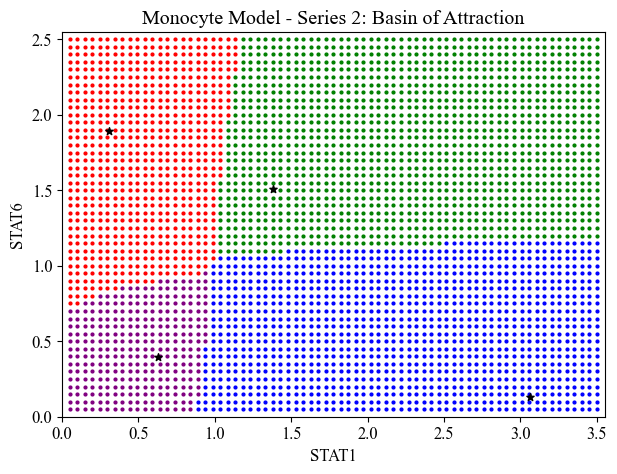

In [6]:
plt.figure(figsize=(7,5))
#plt.plot(nullcline_STAT1,y_nullcline,label='nullcline STAT1')
#plt.plot(y_nullcline,nullcline_STAT6,label='nullcline STAT6')
for state in basin_of_attraction:
    plt.scatter(state[0][0],state[0][1],color=state[-1],s=4)
plt.scatter(x = [ss1[0],ss2[0],ss3[0],ss4[0]],
             y = [ss1[1],ss2[1],ss3[1],ss4[1]],
             color='black',
             s=30,
             marker='*')
plt.title('Monocyte Model - Series 2: Basin of Attraction')
plt.xlim(0,3.55)
plt.ylim(0,2.55)
plt.xlabel('STAT1')
plt.ylabel('STAT6')
plt.yticks([0,0.5,1,1.5,2,2.5])
plt.xticks([0,0.5,1,1.5,2,2.5,3,3.5])
plt.show()

### Sensibility Analysis

In [32]:
from SALib.sample import saltelli
from SALib.analyze import sobol

parameters_1 = parameter_extraction(monocyte_model_2)

# define the variable space to randomize
problem = {
    'num_vars':len(parameters_1),
    'names':list(parameters_1.keys())
    }

bounds = []
for param in parameters_1.values():
    interval_p = param + 0.15*param
    interval_m = param - 0.15*param
    int_list = [interval_m,interval_p]
    bounds.append(int_list)

problem['bounds'] = bounds
print(parameters_1)
# randomize inputs through a sample function
param_values = saltelli.sample(problem, 2**13)

{'a1': 15.0, 'a2': 8.0, 'K1': 1.0, 'K2': 1.0, 'P1': 0.5, 'P2': 1.0, 'n1': 22.0, 'n2': 6.0, 'l1': 1.0, 'l2': 1.0, 'b1': 0.05, 'b2': 0.05, 'q1': 5.8, 'q2': 5.8, 'S1': 5.0, 'S2': 5.0}


C:\Users\jpedr\AppData\Local\Temp\ipykernel_41572\1941210969.py:22: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 2**13)


In [33]:
# Define the model
def model(state, t, parameters):
    x1, x2 = state
    a1, a2, K1, K2, p1, p2, n1, n2, l1, l2, b1, b2, q1, q2, s1, s2 = parameters
    
    # Equations of the model
    v1 = (a1*(1/(1+(K1/x1)**n1))+s1)*(1/(1+(x2/p2)**l2))+b1
    v2 = q1*x1
    v3 = a2*(1/(1+(K2/x2)**n2))+s2*(1/(1+(x1/p1)**l1))+b2
    v4 = q2*x2
    
    dX1 = v1 - v2
    dX2 = v3 - v4
    
    return [dX1, dX2]

# Model definitions
state = [1.2,2]
times = np.linspace(0, 40, 40001)

# Solve model for each parameter sample
model_parse_2 = np.zeros((param_values.shape[0],3))
for row in tqdm(range(0,len(param_values))):
    param_set = list(param_values[row,:])
    solution = odeint(model, state, t=times, args=(param_set,))
    sd_state = solution[-1]
    model_parse_2[row][0] = sd_state[0]
    model_parse_2[row][1] = sd_state[1]
    model_parse_2[row][2] = sd_state[0]/sd_state[1]

100%|██████████| 278528/278528 [09:48<00:00, 473.29it/s]


In [35]:
# determine sentivity indeces 
Si_2 = sobol.analyze(problem,model_parse_2[:,2])

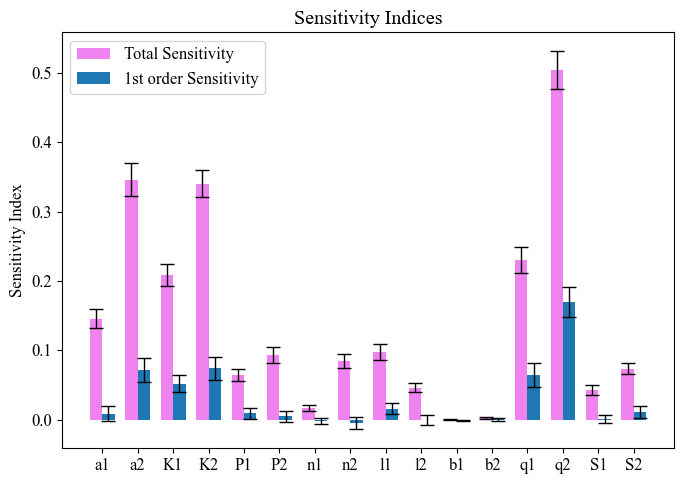

In [39]:
error_kw = {'elinewidth': 2, 'ecolor': 'black', 'capsize': 5, 'capthick': 1}

# Create subplots
f, ax = plt.subplots(1,1, figsize=(7, 5))

# Define the positions for the bars
x = np.arange(len(problem['names']))

width = 0.35  # Width of the bars

# Error bar settings
error_kw = dict(ecolor='black', lw=1, capsize=5, capthick=1)

# Plot the data sets
bar1 = ax.bar(x - width/2, Si_2['ST'], width, yerr=Si_2['ST_conf'], error_kw=error_kw, label='Total Sensitivity',color='violet')
bar2 = ax.bar(x + width/2, Si_2['S1'], width, yerr=Si_2['S1_conf'], error_kw=error_kw, label='1st order Sensitivity')

ax.set_title('Sensitivity Indices')
ax.set_ylabel('Sensitivity Index')
ax.set_xticks(x)
ax.set_xticklabels(problem['names'])
ax.legend()

plt.tight_layout()
plt.show()

## Bifurcation Analysis - NOT WORKING

### Series 0

In [ ]:
# Model to be used
monocyte_model = """
r1: -> STAT1, (a1*(1/(1+(K1/STAT1)**n1)) + S1)*(1/(1+(STAT6/P2)**l2)) + b1
r2: STAT1 ->, q1*STAT1
r3: -> STAT6, a2*(1/(1+(K2/STAT6)**n2))+S2*(1/(1+(STAT1/P1)**l1)) + b2
r4: STAT6 ->, q2*STAT6

a1 = 5
a2 = 5
K1 = 1
K2 = 1
P1 = 0.5
P2 = 1
n1 = 6
n2 = 6
l1 = 1
l2 = 1
b1 = 0.05
b2 = 0.05
q1 = 5
q2 = 5
S1 = 0.01
S2 = 3.75

init:(STAT1=1.2,STAT6=2)

"""

In [86]:
import numpy as np
from scipy.optimize import root
from scipy.optimize import show_options

# Define model based on the stated equations
def model(state, parameter):
    V0 = (parameter['a1']*(1/(1+(parameter['K1']/state[0])**parameter['n1'])) + parameter['S1'])*(1/(1+(state[1]/parameter['P2'])**parameter['l2'])) + parameter['b1']
    V1 = parameter['q1']*state[0]
    V2 = parameter['a2']*(1/(1+(parameter['K2']/state[1])**parameter['n2']))+parameter['S2']*(1/(1+(state[0]/parameter['P1'])**parameter['l1'])) + parameter['b2']
    V3 = parameter['q2']*state[1]

    dSTAT1 = V0 - V1
    dSTAT6 = V2 - V3
    return np.array([dSTAT1, dSTAT6])

# Define a function that returns the values of dSTAT1 and dSTAT6
def func(state, parameter):
    return model(state, parameter)

# Define a function that returns the difference between the desired values and the computed values
def equation(state, parameter):
    return func(state, parameter) - np.array([0, 0])

# Parameters dictionary
parameter = parameter_extraction(monocyte_model)

# Initial guess for the state variables
initial_guess = np.array([0.1, 0.1])

# Solve the system of equations
solutions = []
while len(solutions) != 3:
    sol = root(equation, initial_guess, args=(parameter,),method='df-sane',options={'maxiter':1e+10})
    print(sol.message)
    if sol.success:
        current_solution = [round(x,5) for x in sol.x]
        if tuple(current_solution) not in solutions:
            solutions.append(tuple(current_solution))
        # Update initial guess for the next iteration
        initial_guess = sol.x + np.random.normal(scale=0.1, size=len(initial_guess))
    else:
        print("Couldn't find a solution")
    print(solutions)

print("Solutions:")
for sol in solutions:
    print(sol)

[0.5951801713038596, 0.3543863958036817]
[0.26332737562504893, 1.3697924293909933]
[0.17112088605003428, 1.4827638273559884]
[0.0872077258668148, 1.590420034133679]
[0.017423439887449422, 1.6941687857931547]
[0.010739334904248391, 1.7051340198361231]


successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518, 0.35439)]
successful convergence
[(0.59518

C:\Users\jpedr\AppData\Local\Temp\ipykernel_42116\519113276.py:33: OptimizeWarning: Unknown solver options: maxiter
  sol = root(equation, initial_guess, args=(parameter,),method='df-sane',options={'maxiter':1e+10})


[0.010739334904248391, 1.7051340198361231]

In [ ]:
# Define model based on the stated equations
def model(state, parameter):
    V0 = (parameter['a1']*(1/(1+(parameter['K1']/state[0])**parameter['n1'])) + parameter['S1'])*(1/(1+(state[1]/parameter['P2'])**parameter['l2'])) + parameter['b1']
    V1 = parameter['q1']*state[0]
    V2 = parameter['a2']*(1/(1+(parameter['K2']/state[1])**parameter['n2']))+parameter['S2']*(1/(1+(state[0]/parameter['P1'])**parameter['l1'])) + parameter['b2']
    V3 = parameter['q2']*state[1]

    dSTAT1 = V0 - V1
    dSTAT6 = V2 - V3
    return np.array([dSTAT1, dSTAT6])

# Define a function that returns the values of dSTAT1 and dSTAT6
def func(state, parameter):
    return model(state, parameter)

# Define a function that returns the difference between the desired values and the computed values
def equation(state, parameter):
    return func(state, parameter) - np.array([0, 0])

ss_1 = []
ss_2 = []
ss_3 = []

# Define initial guess
initial_guess = np.array([1.75,0.25])

# Create a variation range for a given parameter
param_range = np.linspace(0,15,1501)[1:]

# Find the steady state values for the parameter variation
i = 0
for value in tqdm(param_range):
    model_s1 = script(monocyte_model,'S1',value,False)
    model_s1_param = parameter_extraction(model_s1)
    solutions = []
    #while len(solutions) != 3:
    for _ in range(200):  # Adjust the number of iterations as needed
        sol = root(equation, initial_guess, args=(model_s1_param,),tol=1e+8)
        if sol.success:
            current_solution = [round(x,4) for x in sol.x]
            if tuple(current_solution) not in solutions:
                solutions.append(tuple(current_solution))
            # Update initial guess for the next iteration
            initial_guess = sol.x + np.random.normal(scale=0.1, size=len(initial_guess))
        else:
            print("Couldn't find a solution")
    i += 1
    x_solution = [sol[0] for sol in solutions]
    s1_index = x_solution.index(max(x_solution))
    s3_index = x_solution.index(min(x_solution))
    ss_1.append(x_solution[s1_index])
    ss_3.append(x_solution[s3_index])


100%|██████████| 1500/1500 [00:25<00:00, 58.57it/s]


In [ ]:
print(ss_1)

[0.8487, 0.4615, 0.1417, 0.2755, 0.2117, 0.1967, 0.6499, 0.1971, 0.2598, 0.1808, 0.2503, 0.2401, 0.3057, 0.3671, 0.1824, 0.3545, 0.2244, 0.4039, 0.2327, 0.2187, 0.314, 0.0333, 0.2671, 0.2952, 0.2359, 0.1842, 0.1385, 0.2507, 0.2292, 0.2242, 0.3611, 0.2781, 0.0399, 0.2909, 0.2003, 0.2984, 0.3082, 0.2184, 0.26, 0.1832, 0.2072, 0.2629, 0.2124, 0.1823, 0.2359, 0.2275, 0.2738, 0.5606, 0.2278, 0.4109, 0.2188, 0.2152, 0.2059, 0.2599, 0.3575, 0.2724, 0.3407, 0.2556, 0.2332, 0.2671, 0.2288, 0.1633, 0.2214, 0.2122, 0.2236, 0.3978, 0.2377, 0.2136, 0.1262, 0.2765, 0.2316, 0.2479, 0.224, 0.3039, 0.4115, 0.408, 0.201, 0.1063, 0.1689, 0.2708, 0.5417, 0.3017, 0.2174, 0.2087, 0.3282, 0.3213, 0.1726, 0.3318, 0.3147, 0.4736, 0.2014, 0.4357, 0.4537, 0.1239, 0.1629, 0.0888, 0.1367, 0.1938, 0.2668, 0.2942, 0.1777, 0.3444, 0.328, 0.2442, 0.2511, 0.2274, 0.3671, 0.2283, 0.2765, 0.1586, 0.2547, 0.3157, 0.2953, 0.4433, 27.711, 0.253, 0.2835, 0.228, 0.2327, 0.1967, 0.123, 0.2669, 0.2648, 0.3051, 0.4408, 0.2722, 0

In [ ]:
# Alter the model to suit the analysis for each steady state
monocyte_model_0 = script(monocyte_model_1,'STAT6',0.5,True)
# Create a variation range for a given parameter
param_range = np.linspace(0,15,1501)

STAT1_ss_high = []
STAT1_ss_low = []

# Run the model iterating through every parameter change to assess the SS value of each variable
for param in param_range:
    model_run_high = script(script(monocyte_model_0,'STAT1',1.5,True),'K1',param)
    model_run_low = script(script(monocyte_model_0,'STAT1',0.5,True),'K1',param)
    model_run_high_solve = read_model(model_run_high).solve(npoints=1000,tf=40)
    model_run_low_solve = read_model(model_run_low).solve(npoints=1000,tf=40)
    STAT1_ss_high.append(model_run_high_solve[0][-1])
    STAT1_ss_low.append(model_run_low_solve[0][-1])

# Process the steady states found
for i in range(0,len(STAT1_ss_high)):
    if STAT1_ss_high[i] - STAT1_ss_high[i-1] > 0.5:
        S1_ss_h = STAT1_ss_high[i:]
        param_range_h = param_range[i:]
    if STAT1_ss_low[i] - STAT1_ss_low[i-1] > 0.5:
        param_range_l = param_range[0:i-1]
        S1_ss_l = STAT1_ss_low[0:i-1]
        
S1_ss = S1_ss_l + S1_ss_h
param_range_t = list(param_range_l) + list(param_range_h)

NameError: name 'monocyte_model_1' is not defined

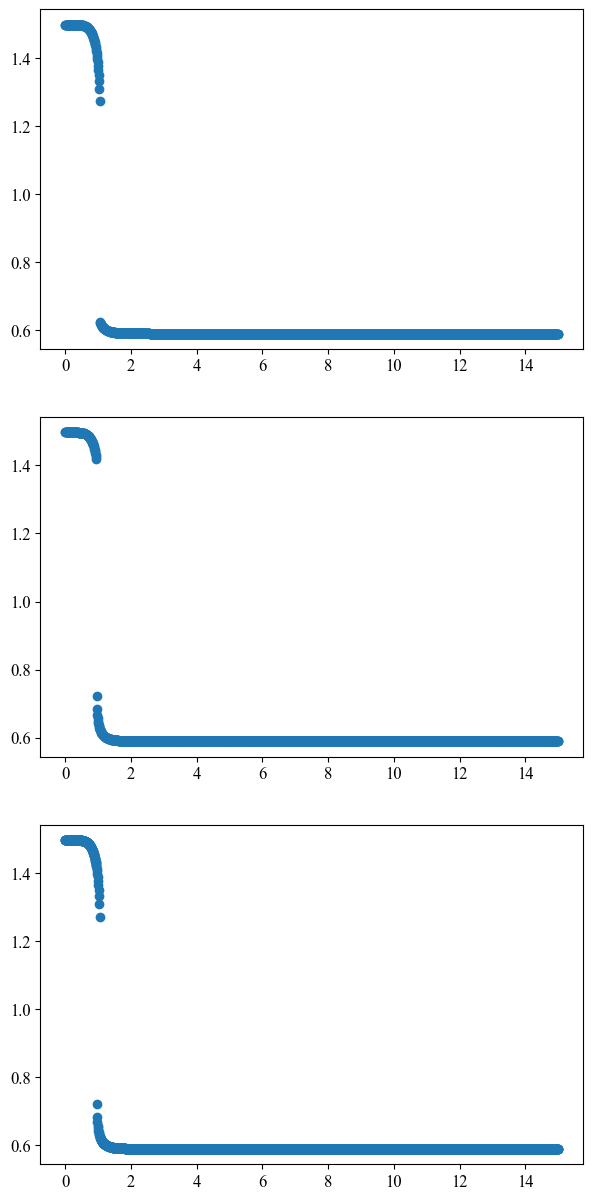

In [ ]:
# Plot the SS value variation with the parameter variation
f, ax = plt.subplots(3,1,figsize=(7,15))

ax[0].scatter(param_range,STAT1_ss_high)
ax[1].scatter(param_range,STAT1_ss_low)
ax[2].scatter(param_range_t,S1_ss)
plt.show()

## Test model

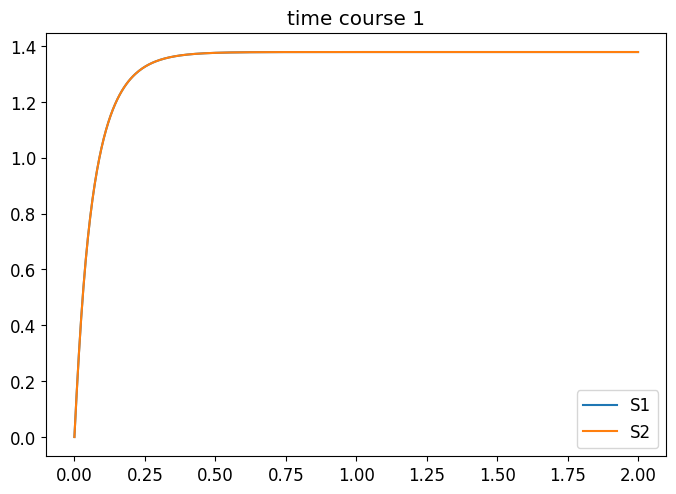

In [ ]:
test_model = """
r1: -> S1, k1*(1/(1+(S2/K2)**n1))
r2: S1 ->, k3*S1
r3: -> S2, k2*(1/(1+(S1/K1)**n2))
r4: S2 ->, k4*S2

k1 = 20
k2 = 20
k3 = 5
k4 = 5
n1 = 2
n2 = 2
K1 = 1
K2 = 1

init:(S1 = 0, S2 = 0)
"""

test_solve = read_model(test_model).solve(tf=2)
test_solve.plot()
plt.show()

In [ ]:
# Create a variation range for a given parameter
param_range = np.linspace(0,35,3500)

S1_ss_high = []
S1_ss_low = []

# Run the model iterating through every parameter change to assess the SS value of each variable
for param in param_range:
    model_run_high = script(script(test_model,'S1',2,True),'k1',param)
    model_run_low = script(script(test_model,'S2',2,True),'k1',param)
    model_run_high_solve = read_model(model_run_high).solve(npoints=100,tf=40)
    model_run_low_solve = read_model(model_run_low).solve(npoints=100,tf=40)
    S1_ss_high.append(model_run_high_solve[0][-1])
    S1_ss_low.append(model_run_low_solve[0][-1])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4788


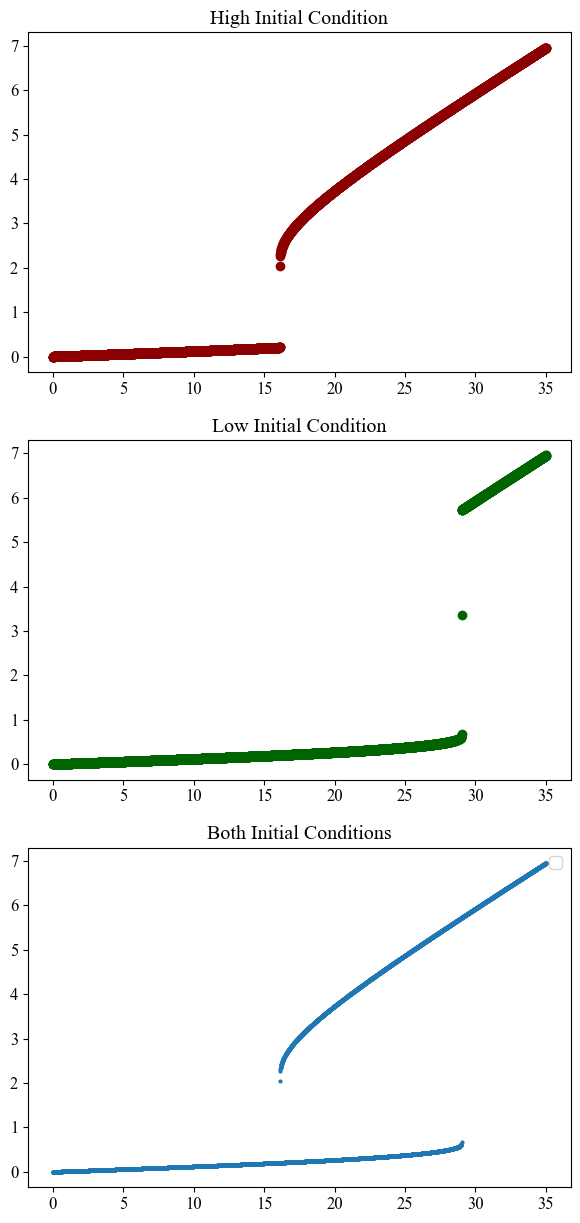

In [ ]:
for i in range(0,len(S1_ss_high)):
    if S1_ss_high[i] - S1_ss_high[i-1] > 0.5:
        S1_ss_h = S1_ss_high[i:]
        param_range_h = param_range[i:]
    if S1_ss_low[i] - S1_ss_low[i-1] > 0.5:
        param_range_l = param_range[0:i-1]
        S1_ss_l = S1_ss_low[0:i-1]
S1_ss = S1_ss_l + S1_ss_h
param_range_t = list(param_range_l) + list(param_range_h)

print(len(S1_ss))
f, ax = plt.subplots(3,1,figsize=(7,15))

ax[0].scatter(param_range,S1_ss_high,color='darkred')
ax[0].set_title('High Initial Condition')
ax[1].scatter(param_range,S1_ss_low,color='darkgreen')
ax[1].set_title('Low Initial Condition')
ax[2].scatter(param_range_t,S1_ss,s=4)
ax[2].set_title('Both Initial Conditions')
plt.legend()
plt.show()